<img src="http://imgur.com/1ZcRyrc.png" style="float: left; margin: 15px; height: 80px">

# Project 3

### Regression and Classification with the Ames Housing Data

---

You have just joined a new "full stack" real estate company in Ames, Iowa. The strategy of the firm is two-fold:
- Own the entire process from the purchase of the land all the way to sale of the house, and anything in between.
- Use statistical analysis to optimize investment and maximize return.

The company is still small, and though investment is substantial the short-term goals of the company are more oriented towards purchasing existing houses and flipping them as opposed to constructing entirely new houses. That being said, the company has access to a large construction workforce operating at rock-bottom prices.

This project uses the [Ames housing data recently made available on kaggle](https://www.kaggle.com/c/house-prices-advanced-regression-techniques).

In [1]:
import numpy as np
import scipy.stats as stats
import seaborn as sns
import matplotlib.pyplot as plt
import pandas as pd


sns.set_style('whitegrid')

%config InlineBackend.figure_format = 'retina'
%matplotlib inline

In [2]:
# import warnings filter
from warnings import simplefilter
# ignore all future warnings
simplefilter(action='ignore', category = FutureWarning)

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 1. Estimating the value of homes from fixed characteristics.

---

Your superiors have outlined this year's strategy for the company:
1. Develop an algorithm to reliably estimate the value of residential houses based on *fixed* characteristics.
2. Identify characteristics of houses that the company can cost-effectively change/renovate with their construction team.
3. Evaluate the mean dollar value of different renovations.

Then we can use that to buy houses that are likely to sell for more than the cost of the purchase plus renovations.

Your first job is to tackle #1. You have a dataset of housing sale data with a huge amount of features identifying different aspects of the house. The full description of the data features can be found in a separate file:

    housing.csv
    data_description.txt
    
You need to build a reliable estimator for the price of the house given characteristics of the house that cannot be renovated. Some examples include:
- The neighborhood
- Square feet
- Bedrooms, bathrooms
- Basement and garage space

and many more. 

Some examples of things that **ARE renovate-able:**
- Roof and exterior features
- "Quality" metrics, such as kitchen quality
- "Condition" metrics, such as condition of garage
- Heating and electrical components

and generally anything you deem can be modified without having to undergo major construction on the house.

---

**Your goals:**
1. Perform any cleaning, feature engineering, and EDA you deem necessary.
- Be sure to remove any houses that are not residential from the dataset.
- Identify **fixed** features that can predict price.
- Train a model on pre-2010 data and evaluate its performance on the 2010 houses.
- Characterize your model. How well does it perform? What are the best estimates of price?

> **Note:** The EDA and feature engineering component to this project is not trivial! Be sure to always think critically and creatively. Justify your actions! Use the data description file!

In [3]:
# Load the data

data_raw = pd.read_csv('./housing.csv')
data_raw.head()

Id  MSSubClass MSZoning  LotFrontage  LotArea Street Alley LotShape  \
0   1          60       RL         65.0     8450   Pave   NaN      Reg   
1   2          20       RL         80.0     9600   Pave   NaN      Reg   
2   3          60       RL         68.0    11250   Pave   NaN      IR1   
3   4          70       RL         60.0     9550   Pave   NaN      IR1   
4   5          60       RL         84.0    14260   Pave   NaN      IR1   

  LandContour Utilities  ... PoolArea PoolQC Fence MiscFeature MiscVal MoSold  \
0         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
1         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      5   
2         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      9   
3         Lvl    AllPub  ...        0    NaN   NaN         NaN       0      2   
4         Lvl    AllPub  ...        0    NaN   NaN         NaN       0     12   

  YrSold  SaleType  SaleCondition  SalePrice  
0   2008        WD         Normal     208500  
1   2007        WD         Normal     181500  
2   2008        WD         Normal     223500  
3   2006        WD        Abnorml     140000  
4   2008        WD         Normal     250000  

[5 rows x 81 columns]

In [4]:
# Basic information of data: data size, type and number of null values

print('House data size: ','column count = ', data_raw.shape[1], ', ', 'row count = ', data_raw.shape[0])
print('-------------------------------------------')
print('Column data types & null value counts below:')
print('-------------------------------------------')
data_raw.info()

House data size:  column count =  81 ,  row count =  1460
-------------------------------------------
Column data types & null value counts below:
-------------------------------------------
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1460 entries, 0 to 1459
Data columns (total 81 columns):
Id               1460 non-null int64
MSSubClass       1460 non-null int64
MSZoning         1460 non-null object
LotFrontage      1201 non-null float64
LotArea          1460 non-null int64
Street           1460 non-null object
Alley            91 non-null object
LotShape         1460 non-null object
LandContour      1460 non-null object
Utilities        1460 non-null object
LotConfig        1460 non-null object
LandSlope        1460 non-null object
Neighborhood     1460 non-null object
Condition1       1460 non-null object
Condition2       1460 non-null object
BldgType         1460 non-null object
HouseStyle       1460 non-null object
OverallQual      1460 non-null int64
OverallCond      1460 n

# 1. Data Cleaning

## 1.1 Remove non-residential properties

#### Identify types of houses

- A  : Agriculture
- C  : Commercial
- FV : Floating Village Residential
- I  : Industrial
- RH : Residential High Density
- RL : Residential Low Density
- RP : Residential Low Density Park 
- RM : Residential Medium Density

In [5]:
# Check what types of properties there are in the 'House' data

print(data_raw.MSZoning.unique())
print(data_raw.MSZoning.value_counts())

['RL' 'RM' 'C (all)' 'FV' 'RH']
RL         1151
RM          218
FV           65
RH           16
C (all)      10
Name: MSZoning, dtype: int64


In [6]:
# Remove all commercial (C) properties

house_raw = data_raw[data_raw.MSZoning != 'C (all)']
house_raw.MSZoning.value_counts()

RL    1151
RM     218
FV      65
RH      16
Name: MSZoning, dtype: int64

## 1.2 Clean null values

In [7]:
# Find names of columns that contain null values
null_col = house_raw.columns[house_raw.isnull().any()]

# Count number of null cells for each column
house_raw[null_col].isnull().sum()

LotFrontage      259
Alley           1361
MasVnrType         8
MasVnrArea         8
BsmtQual          37
BsmtCond          37
BsmtExposure      38
BsmtFinType1      37
BsmtFinType2      38
Electrical         1
FireplaceQu      681
GarageType        79
GarageYrBlt       79
GarageFinish      79
GarageQual        79
GarageCond        79
PoolQC          1443
Fence           1172
MiscFeature     1398
dtype: int64

In [8]:
# Drop the features with 1000+ null cells as well as 'Id'
house_raw.drop(['Id', 'Alley', 'PoolQC', 'Fence', 'MiscFeature'], axis=1, inplace=True)

print(house_raw.shape)
null_col = house_raw.columns[house_raw.isnull().any()]
print(house_raw[null_col].isnull().sum())

(1450, 76)
LotFrontage     259
MasVnrType        8
MasVnrArea        8
BsmtQual         37
BsmtCond         37
BsmtExposure     38
BsmtFinType1     37
BsmtFinType2     38
Electrical        1
FireplaceQu     681
GarageType       79
GarageYrBlt      79
GarageFinish     79
GarageQual       79
GarageCond       79
dtype: int64


C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\frame.py:3940: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


In [9]:
house_nonull_col = house_raw.columns[~house_raw.isnull().all()]

print('The columns with NO null values : ')
print('-------------------------------------------------------------------------------')
print(house_nonull_col)

The columns with NO null values : 
-------------------------------------------------------------------------------
Index(['MSSubClass', 'MSZoning', 'LotFrontage', 'LotArea', 'Street',
       'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope',
       'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle',
       'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'RoofStyle',
       'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'MasVnrArea',
       'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond',
       'BsmtExposure', 'BsmtFinType1', 'BsmtFinSF1', 'BsmtFinType2',
       'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', 'Heating', 'HeatingQC',
       'CentralAir', 'Electrical', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF',
       'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath',
       'BedroomAbvGr', 'KitchenAbvGr', 'KitchenQual', 'TotRmsAbvGrd',
       'Functional', 'Fireplaces', 'FireplaceQu', 'GarageType', 'GarageYrBlt

### 1.2.1  'LotFrontage' null values

Lot Frontage : Linear feet of street connected to property

In [10]:
print('LotFrontage null value count: ', house_raw.LotFrontage.isnull().sum())
print('Unique values of LotFrontage :')
print(house_raw.LotFrontage.unique())

LotFrontage null value count:  259
Unique values of LotFrontage :
[ 65.  80.  68.  60.  84.  85.  75.  nan  51.  50.  70.  91.  72.  66.
 101.  57.  44. 110.  98.  47. 108. 112.  74. 115.  61.  48.  33.  52.
 100.  24.  89.  63.  76.  81.  95.  69.  21.  32.  78. 121. 122.  40.
  73.  77.  64.  94. 105.  34.  90.  55.  88.  82.  71. 120. 107.  92.
 134.  62.  86. 141.  97.  54.  41.  79. 174.  99.  67.  83.  43. 103.
  93.  30. 129. 140.  35.  37. 118.  87. 116. 150. 111.  49.  96.  59.
  36.  56. 102.  58.  38. 109. 130.  53. 137.  45. 106. 104.  42.  39.
 144. 114. 128. 149. 313. 168. 182. 138. 160. 152. 124. 153.  46.]


count    1191.000000
mean       70.052897
std        24.301013
min        21.000000
25%        59.000000
50%        70.000000
75%        80.000000
max       313.000000
Name: LotFrontage, dtype: float64


Text(0.5, 1.0, 'Distribution of non-null LotFrontage values')

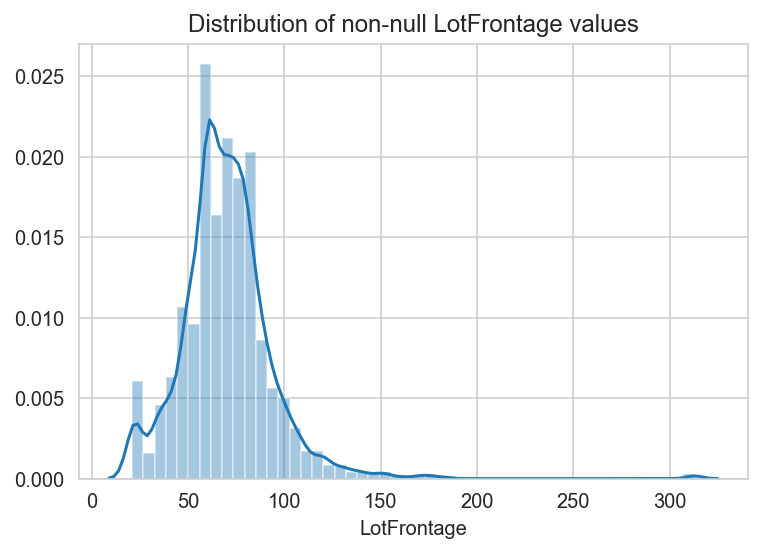

In [11]:
print(house_raw.LotFrontage.describe())
sns.distplot(house_raw['LotFrontage'][~(house_raw.LotFrontage.isnull())]).set_title('Distribution of non-null LotFrontage values')

The median and mean values are very similar and it is fairly normally distributed, so we impute the null cells with the mean value.

In [12]:
house_raw.loc[house_raw.LotFrontage.isnull(), 'LotFrontage'] = house_raw.LotFrontage.mean()

C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 1.2.2 'MasVnrType'  & 'MasVnrArea' null values

- MasVnrType: Masonry veneer type

       BrkCmn	Brick Common
       BrkFace	Brick Face
       CBlock	Cinder Block
       None	None
       Stone	Stone
 
- MasVnrArea: Masonry veneer area in square feet

In [13]:
print('Unique values of MasVnrType:', house_raw.MasVnrType.unique())
print('MasVnrType null value count: ', house_raw.MasVnrType.isnull().sum())
print('MasVnrArea null value count: ', house_raw.MasVnrType.isnull().sum())
house_raw[house_raw.MasVnrType.isnull()][['MasVnrType', 'MasVnrArea']]

Unique values of MasVnrType: ['BrkFace' 'None' 'Stone' 'BrkCmn' nan]
MasVnrType null value count:  8
MasVnrArea null value count:  8


MasVnrType  MasVnrArea
234         NaN         NaN
529         NaN         NaN
650         NaN         NaN
936         NaN         NaN
973         NaN         NaN
977         NaN         NaN
1243        NaN         NaN
1278        NaN         NaN

Wherever the veneer type is NaN, the veneer area is also NaN, so we will replace NaN with 'not_avail'.

In [14]:
house_raw.loc[house_raw.MasVnrType.isnull(), 'MasVnrType'] = 'not_avail'
house_raw.loc[house_raw.MasVnrArea.isnull(), 'MasVnrArea'] = 0

### 1.2.3 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1' & 'BsmtFinType2' null values

- BsmtQual: Evaluates the height of the basement

       Ex	Excellent (100+ inches)	
       Gd	Good (90-99 inches)
       TA	Typical (80-89 inches)
       Fa	Fair (70-79 inches)
       Po	Poor (<70 inches
       NA	No Basement
		
- BsmtCond: Evaluates the general condition of the basement

       Ex	Excellent
       Gd	Good
       TA	Typical - slight dampness allowed
       Fa	Fair - dampness or some cracking or settling
       Po	Poor - Severe cracking, settling, or wetness
       NA	No Basement


- BsmtExposure: Refers to walkout or garden level walls

       Gd	Good Exposure
       Av	Average Exposure (split levels or foyers typically score average or above)	
       Mn	Mimimum Exposure
       No	No Exposure
       NA	No Basement

- BsmtFinType1 & 2: Rating of basement finished area

       GLQ	Good Living Quarters
       ALQ	Average Living Quarters
       BLQ	Below Average Living Quarters	
       Rec	Average Rec Room
       LwQ	Low Quality
       Unf	Unfinshed
       NA	No Basement



Check if fixed 'Bsmt' features have the NAs in the same rows.

In [15]:
Bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']

for i in range(len(Bsmt)):
    print('Unique values of ', Bsmt[i], ':', house_raw[Bsmt[i]].unique())
    print(Bsmt[i],' null value count: ', house_raw[Bsmt[i]].isnull().sum())
    print('-----------------------------------------------------------------------------------')

Unique values of  BsmtQual : ['Gd' 'TA' 'Ex' nan 'Fa']
BsmtQual  null value count:  37
-----------------------------------------------------------------------------------
Unique values of  BsmtCond : ['TA' 'Gd' nan 'Fa' 'Po']
BsmtCond  null value count:  37
-----------------------------------------------------------------------------------
Unique values of  BsmtExposure : ['No' 'Gd' 'Mn' 'Av' nan]
BsmtExposure  null value count:  38
-----------------------------------------------------------------------------------
Unique values of  BsmtFinType1 : ['GLQ' 'ALQ' 'Unf' 'Rec' 'BLQ' nan 'LwQ']
BsmtFinType1  null value count:  37
-----------------------------------------------------------------------------------
Unique values of  BsmtFinType2 : ['Unf' 'BLQ' nan 'ALQ' 'Rec' 'LwQ' 'GLQ']
BsmtFinType2  null value count:  38
-----------------------------------------------------------------------------------


In [16]:
Bsmt_null = house_raw[Bsmt].index[house_raw[Bsmt].isnull().all(1)]   
print('There are ', len(Bsmt_null), ' rows where all Bsmt cells are null.')
print('This indicates there is a null cell unique to "BsmtExposure" and "BsmtFinType2".')

There are  37  rows where all Bsmt cells are null.
This indicates there is a null cell unique to "BsmtExposure" and "BsmtFinType2".


In [17]:
house_raw[house_raw.BsmtQual.isnull()][Bsmt]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
17        NaN      NaN          NaN          NaN          NaN
39        NaN      NaN          NaN          NaN          NaN
90        NaN      NaN          NaN          NaN          NaN
102       NaN      NaN          NaN          NaN          NaN
156       NaN      NaN          NaN          NaN          NaN
182       NaN      NaN          NaN          NaN          NaN
259       NaN      NaN          NaN          NaN          NaN
342       NaN      NaN          NaN          NaN          NaN
362       NaN      NaN          NaN          NaN          NaN
371       NaN      NaN          NaN          NaN          NaN
392       NaN      NaN          NaN          NaN          NaN
520       NaN      NaN          NaN          NaN          NaN
532       NaN      NaN          NaN          NaN          NaN
533       NaN      NaN          NaN          NaN          NaN
553       NaN      NaN          NaN          NaN          NaN
646       NaN      NaN          NaN          NaN          NaN
705       NaN      NaN          NaN          NaN          NaN
736       NaN      NaN          NaN          NaN          NaN
749       NaN      NaN          NaN          NaN          NaN
778       NaN      NaN          NaN          NaN          NaN
868       NaN      NaN          NaN          NaN          NaN
894       NaN      NaN          NaN          NaN          NaN
897       NaN      NaN          NaN          NaN          NaN
984       NaN      NaN          NaN          NaN          NaN
1000      NaN      NaN          NaN          NaN          NaN
1011      NaN      NaN          NaN          NaN          NaN
1035      NaN      NaN          NaN          NaN          NaN
1045      NaN      NaN          NaN          NaN          NaN
1048      NaN      NaN          NaN          NaN          NaN
1049      NaN      NaN          NaN          NaN          NaN
1090      NaN      NaN          NaN          NaN          NaN
1179      NaN      NaN          NaN          NaN          NaN
1216      NaN      NaN          NaN          NaN          NaN
1218      NaN      NaN          NaN          NaN          NaN
1232      NaN      NaN          NaN          NaN          NaN
1321      NaN      NaN          NaN          NaN          NaN
1412      NaN      NaN          NaN          NaN          NaN

In [18]:
Bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
    
# Find a list of index numbers where all Bsmt cells are null
Bsmt_AllNull = house_raw[Bsmt].index[house_raw[Bsmt].isnull().all(1)]   

# Where all Bsmt cells are null, we will put 'not_avail'
for elem in Bsmt:
    for index in Bsmt_AllNull:
        house_raw.loc[index, elem] = 'not_avail'

In [19]:
# Find Id(s) where not all Bsmt cells are null

for i in range(len(Bsmt)):
    df_Bsmt_AnyNull = house_raw[Bsmt[i]].index[house_raw[Bsmt[i]].isnull()]
    for index in df_Bsmt_AnyNull:
        if index not in Bsmt_AllNull:
            print('Index ', index, ' contains a null unique to ', Bsmt[i], '.') 

Index  948  contains a null unique to  BsmtExposure .
Index  332  contains a null unique to  BsmtFinType2 .


In [20]:
pd.DataFrame(house_raw.loc[948]).T[Bsmt]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
948       Gd       TA          NaN          Unf          Unf

In [21]:
house_raw.loc[948][Bsmt]

BsmtQual         Gd
BsmtCond         TA
BsmtExposure    NaN
BsmtFinType1    Unf
BsmtFinType2    Unf
Name: 948, dtype: object

In [22]:
# It appears that the basement is unfinished, so we will put 'Unf'

house_raw.loc[948, 'BsmtExposure'] = 'Unf'

In [23]:
pd.DataFrame(house_raw.loc[332]).T[Bsmt]

BsmtQual BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
332       Gd       TA           No          GLQ          NaN

In [24]:
Bsmt = ['BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']
house_raw[house_raw.BsmtFinType2 != 'Unf'][['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]

BsmtCond BsmtExposure BsmtFinType1 BsmtFinType2
7            TA           Mn          ALQ          BLQ
17    not_avail    not_avail    not_avail    not_avail
24           TA           Mn          Rec          ALQ
26           TA           Mn          BLQ          Rec
39    not_avail    not_avail    not_avail    not_avail
42           TA           Av          ALQ          LwQ
43           TA           Av          LwQ          BLQ
44           TA           No          ALQ          BLQ
52           TA           Gd          LwQ          GLQ
73           TA           No          ALQ          BLQ
77           TA           No          BLQ          GLQ
90    not_avail    not_avail    not_avail    not_avail
102   not_avail    not_avail    not_avail    not_avail
107          TA           No          ALQ          BLQ
113          TA           Mn          ALQ          Rec
114          TA           No          ALQ          LwQ
116          TA           No          LwQ          BLQ
129          TA           No          Rec          BLQ
153          TA           Gd          BLQ          ALQ
156   not_avail    not_avail    not_avail    not_avail
165          TA           No          ALQ          Rec
166          TA           No          LwQ          BLQ
172          Gd           No          GLQ          Rec
173          TA           No          ALQ          Rec
174          Fa           No          ALQ          LwQ
177          TA           No          ALQ          BLQ
182   not_avail    not_avail    not_avail    not_avail
197          TA           No          GLQ          LwQ
201          TA           No          ALQ          LwQ
207          TA           No          ALQ          Rec
...         ...          ...          ...          ...
1232  not_avail    not_avail    not_avail    not_avail
1242         TA           Gd          GLQ          LwQ
1249         TA           No          BLQ          Rec
1253         TA           Gd          LwQ          ALQ
1259         TA           No          ALQ          LwQ
1272         TA           No          BLQ          LwQ
1282         TA           Mn          LwQ          Rec
1286         TA           No          ALQ          Rec
1299         TA           No          LwQ          Rec
1308         TA           No          GLQ          ALQ
1315         TA           Mn          ALQ          LwQ
1320         TA           No          ALQ          Rec
1321  not_avail    not_avail    not_avail    not_avail
1346         TA           No          BLQ          Rec
1367         TA           No          ALQ          Rec
1369         TA           Av          BLQ          GLQ
1370         TA           No          ALQ          Rec
1377         TA           No          LwQ          BLQ
1386         TA           No          BLQ          LwQ
1387         TA           No          Rec          LwQ
1396         TA           Av          BLQ          Rec
1398         TA           No          Rec          BLQ
1412  not_avail    not_avail    not_avail    not_avail
1418         TA           No          BLQ          Rec
1424         TA           No          ALQ          Rec
1439         TA           No          GLQ          Rec
1445         TA           Gd          LwQ          Rec
1456         TA           No          ALQ          Rec
1458         TA           Mn          GLQ          Rec
1459         TA           No          BLQ          LwQ

[204 rows x 4 columns]

It appears that the 2nd basement exists, but the data is not available for 'BsmtFinType2'. 

In [25]:
## Impute with KNN

from sklearn.neighbors import KNeighborsRegressor, KNeighborsClassifier
from sklearn.model_selection import cross_val_score
from sklearn.preprocessing import StandardScaler

In [26]:
house_raw.loc[332][Bsmt]

BsmtQual         Gd
BsmtCond         TA
BsmtExposure     No
BsmtFinType1    GLQ
BsmtFinType2    NaN
Name: 332, dtype: object

In [27]:
house_raw.BsmtFinType2.value_counts()

Unf          1246
Rec            54
LwQ            46
not_avail      37
BLQ            33
ALQ            19
GLQ            14
Name: BsmtFinType2, dtype: int64

In [28]:
# Remove 'Unf' and 'not_avail' rows
house_BsmtFinType2 = house_raw[house_raw.BsmtFinType2 != 'Unf'][['BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2']]
house_BsmtFinType2 = house_BsmtFinType2[house_BsmtFinType2.BsmtFinType2 != 'not_avail']
house_BsmtFinType2.shape

(167, 4)

Replace classes of BsmtFinType2 with id numbers.

In [29]:
BsmtFinType2_conv = house_BsmtFinType2.BsmtFinType2.map(lambda x: 1 if x == 'GLQ' 
                                                        else 2 if x == 'ALQ' 
                                                        else 3 if x == 'BLQ'
                                                        else 4 if x == 'Rec'
                                                        else 5 if x == 'LwQ'
                                                        else x)
BsmtFinType2_conv = pd.DataFrame(BsmtFinType2_conv)
BsmtFinType2_conv.head()

BsmtFinType2
7            3.0
24           2.0
26           4.0
42           5.0
43           3.0

In [30]:
BsmtCond_dummy = pd.get_dummies(house_BsmtFinType2.BsmtCond)
BsmtExposure_dummy = pd.get_dummies(house_BsmtFinType2.BsmtExposure)
BsmtExposure_dummy.head()

Av  Gd  Mn  No
7    0   0   1   0
24   0   0   1   0
26   0   0   1   0
42   1   0   0   0
43   1   0   0   0

In [31]:
BsmtFinType1_dummy = pd.get_dummies(house_BsmtFinType2.BsmtFinType1)
BsmtFinType1_dummy.rename(columns = {'ALQ' : 'Type1_ALQ',
                                     'BLQ' : 'Type1_BLQ', 
                                     'GLQ' : 'Type1_GLQ', 
                                     'LwQ' : 'Type1_LwQ', 
                                     'Rec' : 'Type1_Rec', 
                                     'Unf' : 'Type1_Unf'
                                      }, inplace=True)
BsmtFinType1_dummy.head()

Type1_ALQ  Type1_BLQ  Type1_GLQ  Type1_LwQ  Type1_Rec
7           1          0          0          0          0
24          0          0          0          0          1
26          0          1          0          0          0
42          1          0          0          0          0
43          0          0          0          1          0

Concatenate dummified columns together.

In [32]:
BsmtFinType2_dummied = pd.concat([BsmtCond_dummy, BsmtExposure_dummy, BsmtFinType1_dummy, BsmtFinType2_conv], axis=1)
BsmtFinType2_dummied.head()

Fa  Gd  TA  Av  Gd  Mn  No  Type1_ALQ  Type1_BLQ  Type1_GLQ  Type1_LwQ  \
7    0   0   1   0   0   1   0          1          0          0          0   
24   0   0   1   0   0   1   0          0          0          0          0   
26   0   0   1   0   0   1   0          0          1          0          0   
42   0   0   1   1   0   0   0          1          0          0          0   
43   0   0   1   1   0   0   0          0          0          0          1   

    Type1_Rec  BsmtFinType2  
7           0           3.0  
24          1           2.0  
26          0           4.0  
42          0           5.0  
43          0           3.0

In [33]:
BsmtFinType2_dummied.loc[BsmtFinType2_dummied.BsmtFinType2.isnull()]

Fa  Gd  TA  Av  Gd  Mn  No  Type1_ALQ  Type1_BLQ  Type1_GLQ  Type1_LwQ  \
332   0   0   1   0   0   0   1          0          0          1          0   

     Type1_Rec  BsmtFinType2  
332          0           NaN

In [34]:
impute_missing = BsmtFinType2_dummied.loc[BsmtFinType2_dummied.BsmtFinType2.isnull()]
impute_valid = BsmtFinType2_dummied.loc[~BsmtFinType2_dummied.BsmtFinType2.isnull()]
print(impute_missing.shape, impute_valid.shape)
#print(impute_valid.columns)

(1, 13) (166, 13)


In [35]:
impute_cols = [c for c in impute_valid.columns if not c in ['BsmtFinType2']]

y = impute_valid[['BsmtFinType2']].values.ravel()
X = impute_valid[impute_cols].astype(float)

In [36]:
# Standardize predictor matrix
ss = StandardScaler()
Xs = ss.fit_transform(X)

In [37]:
# Find the accuracy and best K for predicting BsmtFinSF2

def find_best_k_cls(X, y, k_min=1, k_max=51, step=2, cv=5):
    k_range = list(range(k_min, k_max+1, step))
    accs = []
    for k in k_range:
        knn = KNeighborsClassifier(n_neighbors=k)
        scores = cross_val_score(knn, X, y, cv=cv)
        accs.append(np.mean(scores))
    print(np.max(accs), np.argmax(k_range))

In [38]:
accs_kbest = find_best_k_cls(Xs, y)

0.38835752482811303 25


#### Calculate baseline

BsmtType2 : 
- 'Rec'      4.0       54
- 'LwQ'      5.0       46
- 'BLQ'      3.0       33
- 'ALQ'      2.0       19
- 'GLQ'      1.0       14


In [39]:
# We are exclusing 'Unf' data points
baseline_BsmtFinType2 = 54/(54+46+33+19+14+1)
baseline_BsmtFinType2

0.32335329341317365

* KNN model score      : 0.39
* Baselien model score : 0.32

The KNN  model will give better classification than the baseline model, so we will fill the KNN model and impute the predicted BsmtFinType2.

In [40]:
knn = KNeighborsClassifier(n_neighbors=25)
knn.fit(Xs, y)

X_miss = impute_missing[impute_cols].astype(float)
X_miss_s = ss.transform(X_miss)


pred_BsmtFinType2 = knn.predict(X_miss_s)
if pred_BsmtFinType2 == 1.0:
    print('BsmtFinType2 = GLQ')
elif pred_BsmtFinType2 == 2.0:
    print('BsmtFinType2 = ALQ')
elif pred_BsmtFinType2 == 3.0:
    print('BsmtFinType2 = BLQ')
elif pred_BsmtFinType2 == 4.0:
    print('BsmtFinType2 = Rec')
elif pred_BsmtFinType2 == 5.0:
    print('BsmtFinType2 = LwQ')
else:
    print("Something's gone wrong!")

BsmtFinType2 = Rec


We'll impute 'Rec' to the null cell.

In [41]:
house_raw.loc[332, 'BsmtFinType2'] = 'Rec'

C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 1.2.4 Electrical null values

Electrical: Electrical system

       SBrkr	Standard Circuit Breakers & Romex
       FuseA	Fuse Box over 60 AMP and all Romex wiring (Average)	
       FuseF	60 AMP Fuse Box and mostly Romex wiring (Fair)
       FuseP	60 AMP Fuse Box and mostly knob & tube wiring (poor)
       Mix	Mixed

In [42]:
print('Unique values of Electrical:', house_raw['Electrical'].unique())
print('Electrical null value count: ', house_raw['Electrical'].isnull().sum())
house_raw[house_raw['Electrical'].isnull()][['Electrical', 'Heating', 'CentralAir']].head()

Unique values of Electrical: ['SBrkr' 'FuseF' 'FuseA' 'FuseP' 'Mix' nan]
Electrical null value count:  1


Electrical Heating CentralAir
1379        NaN    GasA          Y

In [43]:
utility = ['Electrical', 'Heating', 'CentralAir']
house_utility = house_raw[utility]
house_utility.loc[1379]

Electrical     NaN
Heating       GasA
CentralAir       Y
Name: 1379, dtype: object

In [44]:
Electrical_conv = house_utility.Electrical.map(lambda x: 1 if x == 'SBrkr'
                                              else 2 if x == 'FuseA'
                                              else 3 if x == 'FuseF'
                                              else 4 if x == 'FuseP'
                                              else 5 if x == 'Mix'
                                              else x)
Electrical_conv = pd.DataFrame(Electrical_conv)

In [45]:
Heating_dummy = pd.get_dummies(house_utility.Heating)
CentralAir_dummy = pd.get_dummies(house_utility.CentralAir)

utility_dummied = pd.concat([Electrical_conv, Heating_dummy, CentralAir_dummy], axis=1)
utility_dummied.head()

Electrical  Floor  GasA  GasW  Grav  OthW  Wall  N  Y
0         1.0      0     1     0     0     0     0  0  1
1         1.0      0     1     0     0     0     0  0  1
2         1.0      0     1     0     0     0     0  0  1
3         1.0      0     1     0     0     0     0  0  1
4         1.0      0     1     0     0     0     0  0  1

In [46]:
impute_missing = utility_dummied.loc[utility_dummied.Electrical.isnull()]
impute_valid = utility_dummied.loc[~utility_dummied.Electrical.isnull()]
print(impute_missing.shape, impute_valid.shape)

(1, 9) (1449, 9)


In [47]:
impute_cols = [c for c in impute_valid.columns if not c in ['Electrical']]

# Set up y, X
y = impute_valid[['Electrical']].values.ravel()
X = impute_valid[impute_cols].astype(float)

# Standardize X
ss = StandardScaler()
Xs = ss.fit_transform(X)

# from the previously defined function, find_best_k_cls, find the accuracy and best K
accs_kbest = find_best_k_cls(Xs, y)

C:\Users\norik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)
C:\Users\norik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The mi

0.9172079260997943 25


C:\Users\norik\Anaconda3\lib\site-packages\sklearn\model_selection\_split.py:652: Warning: The least populated class in y has only 1 members, which is too few. The minimum number of members in any class cannot be less than n_splits=5.
  % (min_groups, self.n_splits)), Warning)


#### Calculate baseline

Electrical : 
- 'SBrkr'      1.0       1328
- 'FuseA'      2.0       90
- 'FuseF'      3.0       27
- 'FuseP'      4.0       3
- 'Mix'        5.0       1

In [48]:
# Baseline accuracy
baseline_utility = 1328/1450
baseline_utility

0.9158620689655173

* KNN model score      : 0.92
* Baselien model score : 0.92

Both KNN and baseline models give similar score, so we will impute the most frequent category, 'SBrkr.

In [49]:
house_raw.loc[1379, 'Electrical'] = 'SBrkr'
#house_raw.Electrical.value_counts()

C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\indexing.py:543: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self.obj[item] = s


### 1.2.5 FireplaceQu null values

FireplaceQu: Fireplace quality

       Ex	Excellent - Exceptional Masonry Fireplace
       Gd	Good - Masonry Fireplace in main level
       TA	Average - Prefabricated Fireplace in main living area or Masonry Fireplace in basement
       Fa	Fair - Prefabricated Fireplace in basement
       Po	Poor - Ben Franklin Stove
       NA	No Fireplace

In [50]:
print('Unique values of FireplaceQu:', house_raw['FireplaceQu'].unique())
print('FireplaceQu null value count: ', house_raw['FireplaceQu'].isnull().sum())
house_raw[house_raw['FireplaceQu'].isnull()][['Fireplaces', 'FireplaceQu']].head()

Unique values of FireplaceQu: [nan 'TA' 'Gd' 'Fa' 'Ex' 'Po']
FireplaceQu null value count:  681


Fireplaces FireplaceQu
0            0         NaN
5            0         NaN
10           0         NaN
12           0         NaN
15           0         NaN

Find whether FireplaceQu = NaN corresponds with Fireplaces == 0.

In [51]:
FireplaceQu_null = house_raw.index[house_raw['FireplaceQu'].isnull()]  


index_no_fireplace = []
for index in FireplaceQu_null:
    #print(index)
    if house_raw['Fireplaces'][index] == 0:
        index_no_fireplace.append(index)
print(len(index_no_fireplace))

681


It appears that where FireplaceQu is NaN, the Fireplaces cell always show 0.

In [52]:
house_raw.loc[house_raw['FireplaceQu'].isnull(), 'FireplaceQu'] = 'No_Fireplace'

### 1.2.6 Garage null values

- GarageType: Garage location
		
       2Types	More than one type of garage
       Attchd	Attached to home
       Basment	Basement Garage
       BuiltIn	Built-In (Garage part of house - typically has room above garage)
       CarPort	Car Port
       Detchd	Detached from home
       NA	No Garage
		
- GarageYrBlt: Year garage was built
		
- GarageFinish: Interior finish of the garage

       Fin	Finished
       RFn	Rough Finished	
       Unf	Unfinished
       NA	No Garage

In [53]:
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']

for i in range(len(Garage)):
    print('Unique values of ', Garage[i], ':', house_raw[Garage[i]].unique())
    print(Garage[i],' null value count: ', house_raw[Garage[i]].isnull().sum())
    print('-----------------------------------------------------------------------------------')

Unique values of  GarageType : ['Attchd' 'Detchd' 'BuiltIn' 'CarPort' nan 'Basment' '2Types']
GarageType  null value count:  79
-----------------------------------------------------------------------------------
Unique values of  GarageYrBlt : [2003. 1976. 2001. 1998. 2000. 1993. 2004. 1973. 1931. 1939. 1965. 2005.
 1962. 2006. 1960. 1991. 1970. 1967. 1958. 1930. 2002. 1968. 2007. 2008.
 1957. 1920. 1966. 1959. 1995. 1954. 1953.   nan 1983. 1977. 1997. 1985.
 1963. 1981. 1964. 1999. 1935. 1990. 1945. 1987. 1989. 1915. 1956. 1948.
 1974. 2009. 1950. 1961. 1921. 1979. 1951. 1969. 1936. 1975. 1971. 1923.
 1984. 1926. 1955. 1986. 1988. 1916. 1932. 1972. 1918. 1980. 1924. 1996.
 1940. 1949. 1994. 1910. 1978. 1982. 1992. 1925. 1941. 2010. 1927. 1947.
 1937. 1942. 1938. 1952. 1928. 1922. 1934. 1906. 1914. 1946. 1908. 1929.
 1933.]
GarageYrBlt  null value count:  79
-----------------------------------------------------------------------------------
Unique values of  GarageFinish : ['RFn' 'Unf'

Find a list of index numbers where all Garage cells are null

In [54]:
Garage = ['GarageType', 'GarageYrBlt', 'GarageFinish', 'GarageQual', 'GarageCond']
Garage_null = house_raw[Garage].index[house_raw[Garage].isnull().all(1)]   
len(Garage_null)

79

In [55]:
house_raw[house_raw.GarageType.isnull()][Garage]

GarageType  GarageYrBlt GarageFinish GarageQual GarageCond
39          NaN          NaN          NaN        NaN        NaN
48          NaN          NaN          NaN        NaN        NaN
78          NaN          NaN          NaN        NaN        NaN
89          NaN          NaN          NaN        NaN        NaN
99          NaN          NaN          NaN        NaN        NaN
108         NaN          NaN          NaN        NaN        NaN
125         NaN          NaN          NaN        NaN        NaN
127         NaN          NaN          NaN        NaN        NaN
140         NaN          NaN          NaN        NaN        NaN
148         NaN          NaN          NaN        NaN        NaN
155         NaN          NaN          NaN        NaN        NaN
163         NaN          NaN          NaN        NaN        NaN
165         NaN          NaN          NaN        NaN        NaN
198         NaN          NaN          NaN        NaN        NaN
210         NaN          NaN          NaN        NaN        NaN
241         NaN          NaN          NaN        NaN        NaN
250         NaN          NaN          NaN        NaN        NaN
287         NaN          NaN          NaN        NaN        NaN
291         NaN          NaN          NaN        NaN        NaN
307         NaN          NaN          NaN        NaN        NaN
375         NaN          NaN          NaN        NaN        NaN
386         NaN          NaN          NaN        NaN        NaN
393         NaN          NaN          NaN        NaN        NaN
431         NaN          NaN          NaN        NaN        NaN
434         NaN          NaN          NaN        NaN        NaN
441         NaN          NaN          NaN        NaN        NaN
464         NaN          NaN          NaN        NaN        NaN
520         NaN          NaN          NaN        NaN        NaN
528         NaN          NaN          NaN        NaN        NaN
533         NaN          NaN          NaN        NaN        NaN
...         ...          ...          ...        ...        ...
954         NaN          NaN          NaN        NaN        NaN
960         NaN          NaN          NaN        NaN        NaN
968         NaN          NaN          NaN        NaN        NaN
970         NaN          NaN          NaN        NaN        NaN
976         NaN          NaN          NaN        NaN        NaN
1009        NaN          NaN          NaN        NaN        NaN
1011        NaN          NaN          NaN        NaN        NaN
1030        NaN          NaN          NaN        NaN        NaN
1038        NaN          NaN          NaN        NaN        NaN
1096        NaN          NaN          NaN        NaN        NaN
1123        NaN          NaN          NaN        NaN        NaN
1131        NaN          NaN          NaN        NaN        NaN
1137        NaN          NaN          NaN        NaN        NaN
1143        NaN          NaN          NaN        NaN        NaN
1173        NaN          NaN          NaN        NaN        NaN
1179        NaN          NaN          NaN        NaN        NaN
1218        NaN          NaN          NaN        NaN        NaN
1219        NaN          NaN          NaN        NaN        NaN
1234        NaN          NaN          NaN        NaN        NaN
1257        NaN          NaN          NaN        NaN        NaN
1283        NaN          NaN          NaN        NaN        NaN
1323        NaN          NaN          NaN        NaN        NaN
1325        NaN          NaN          NaN        NaN        NaN
1326        NaN          NaN          NaN        NaN        NaN
1337        NaN          NaN          NaN        NaN        NaN
1349        NaN          NaN          NaN        NaN        NaN
1407        NaN          NaN          NaN        NaN        NaN
1449        NaN          NaN          NaN        NaN        NaN
1450        NaN          NaN          NaN        NaN        NaN
1453        NaN          NaN          NaN        NaN        NaN

[79 rows x 5 columns]

It appears that the all 79 garage null values are input across the Garage elements, so we will replace all null values to No_Garage.

In [56]:
for elem in Garage:
    if elem == 'GarageYrBlt':
        house_raw.loc[house_raw[elem].isnull(), elem] = house_raw.loc[house_raw[elem].isnull(), elem]
    else:
        house_raw.loc[house_raw[elem].isnull(), elem] = 'not_avail'

house_raw[Garage].isnull().sum()

GarageType       0
GarageYrBlt     79
GarageFinish     0
GarageQual       0
GarageCond       0
dtype: int64

### Confirm if all null cells are cleaned. 

We will leave the NaNs in GarageYrBlt column to keep its data type as integer for analysis. 

# 2. Exploratory Data Analysis

In [57]:
# We will allocate new variable for house_raw data
house = house_raw

## 2.1 SalePrice distribution

Text(0.5, 1.0, 'Boxplot of House Sale Price')

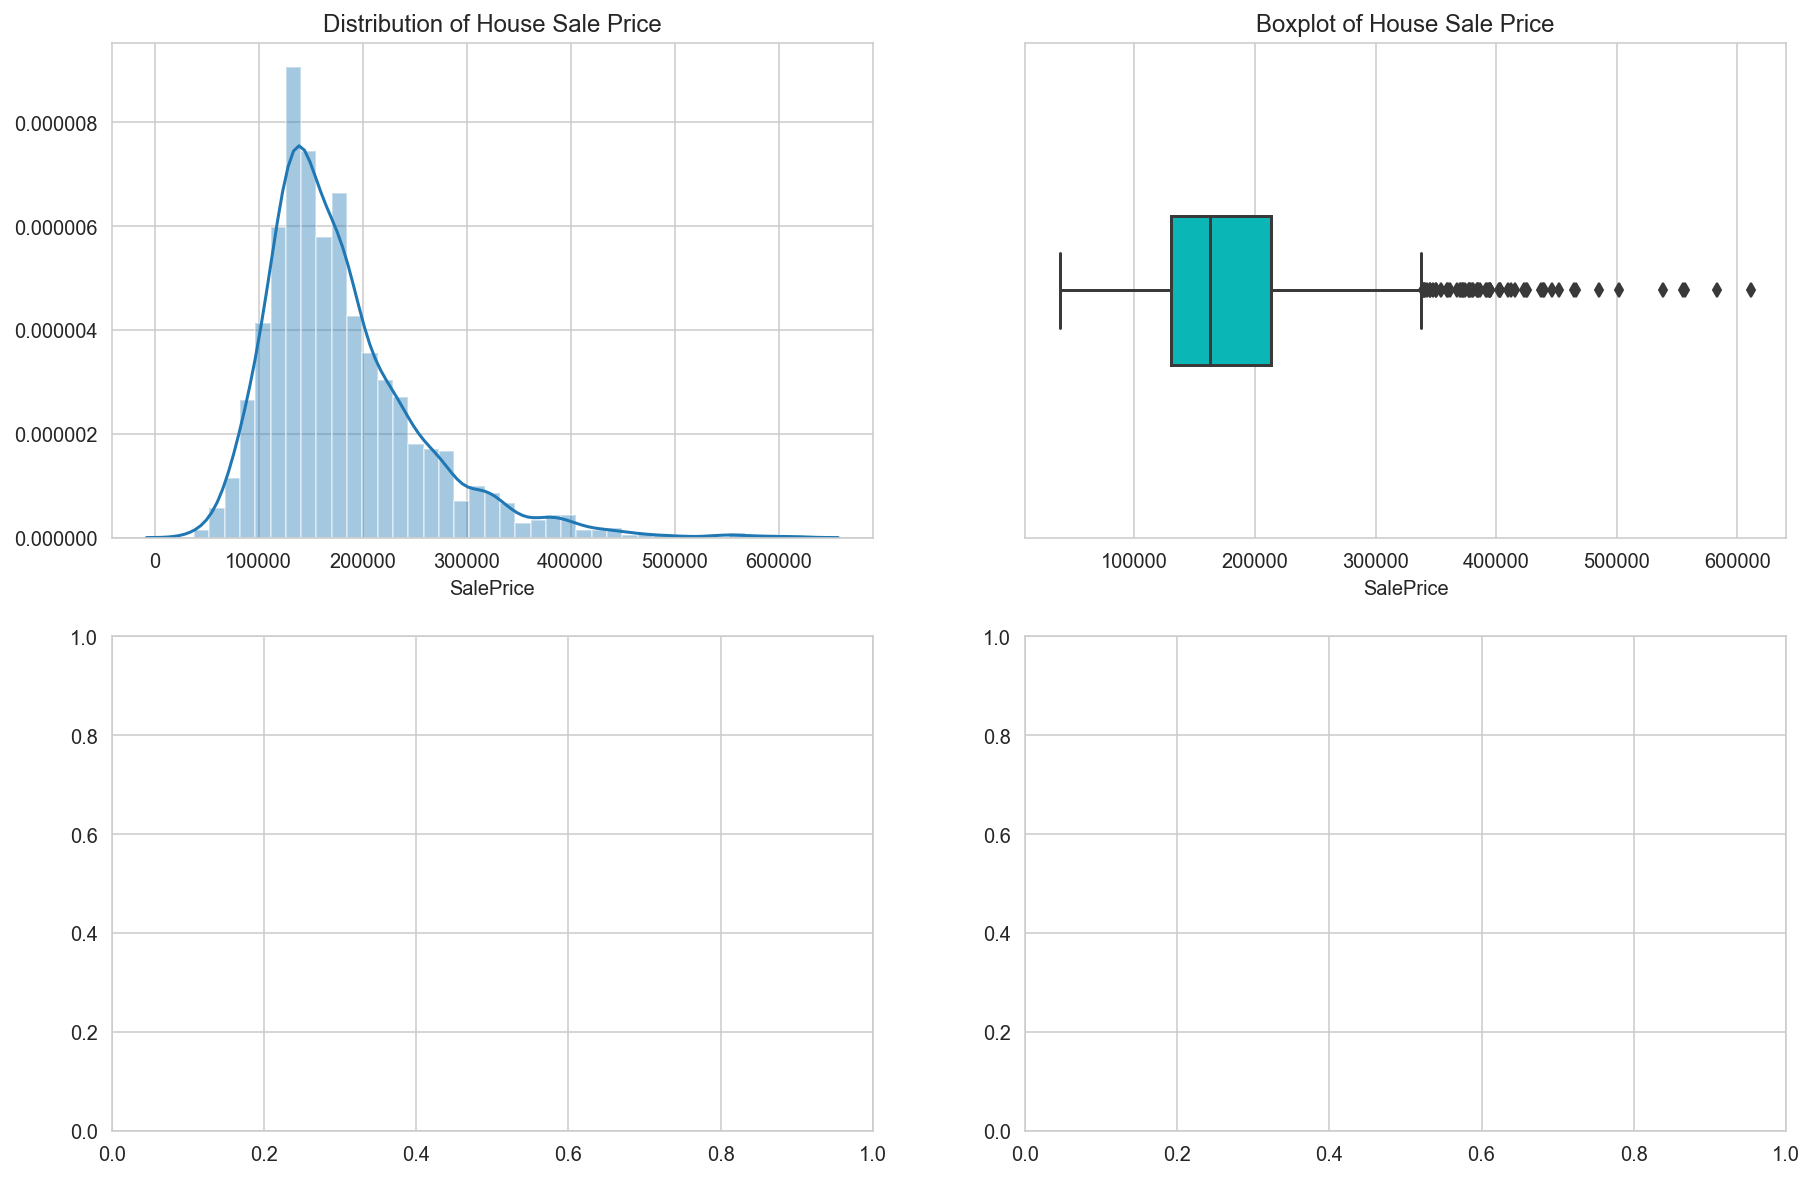

In [144]:
fig, axes = plt.subplots(2, 2, figsize = (15, 10))

sns.distplot(house['SalePrice'], ax=axes[0][0]).set_title('Distribution of House Sale Price')
sns.boxplot(house.SalePrice, orient='h', width = 0.3, saturation=0.9, color='c', ax=axes[0][1], ).set_title('Boxplot of House Sale Price')

In [59]:
# Remove all properties that are greater than $700,000
house = house[house.SalePrice < 700000]

## 2.2 EDA on numerical variables

Make a list of all numerical features

In [60]:
num_original = []

for elem in house.columns:
    if house[elem].dtype == np.int64 or house[elem].dtype == np.float64:
        num_original.append(elem)
print(len(num_original), ' numerical features')
print('--------------------------------------------------------------------------')
print(num_original)

37  numerical features
--------------------------------------------------------------------------
['MSSubClass', 'LotFrontage', 'LotArea', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'MoSold', 'YrSold', 'SalePrice']


In the num_raw list, the following numerical variables represent classes.

['MSSubClass', 'OverallQual', 'OverallCond', 'YearBuilt', 'YearRemodAdd','GarageYrBlt', 'MoSold', 'YrSold']

We will NOT remove below for the purpose of analysis.

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt',  'YrSold'] 

In [61]:
# Removing categorical features that have integer data.
num_class = ['MSSubClass', 'OverallQual', 'OverallCond', 'MoSold']

num_raw = []
for elem in num_original:
    if elem not in num_class:
        num_raw.append(elem)

print(len(num_raw), ' continuous variables')
print('--------------------------------------------------------------------------')
print(num_raw)

33  continuous variables
--------------------------------------------------------------------------
['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 'MiscVal', 'YrSold', 'SalePrice']


In [62]:
num_raw = ['LotFrontage', 'LotArea', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 
           'BsmtFinSF1', 'BsmtFinSF2', 'BsmtUnfSF', 'TotalBsmtSF', '1stFlrSF', 
           '2ndFlrSF', 'LowQualFinSF', 'GrLivArea', 'BsmtFullBath', 'BsmtHalfBath', 
           'FullBath', 'HalfBath', 'BedroomAbvGr', 'KitchenAbvGr', 'TotRmsAbvGrd', 
           'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 
           'OpenPorchSF', 'EnclosedPorch', '3SsnPorch', 'ScreenPorch', 'PoolArea', 
           'MiscVal', 'YrSold', 'SalePrice']

### Correlation plot of numerical variables

Check correlation between numerical variables & check highly correlated variables

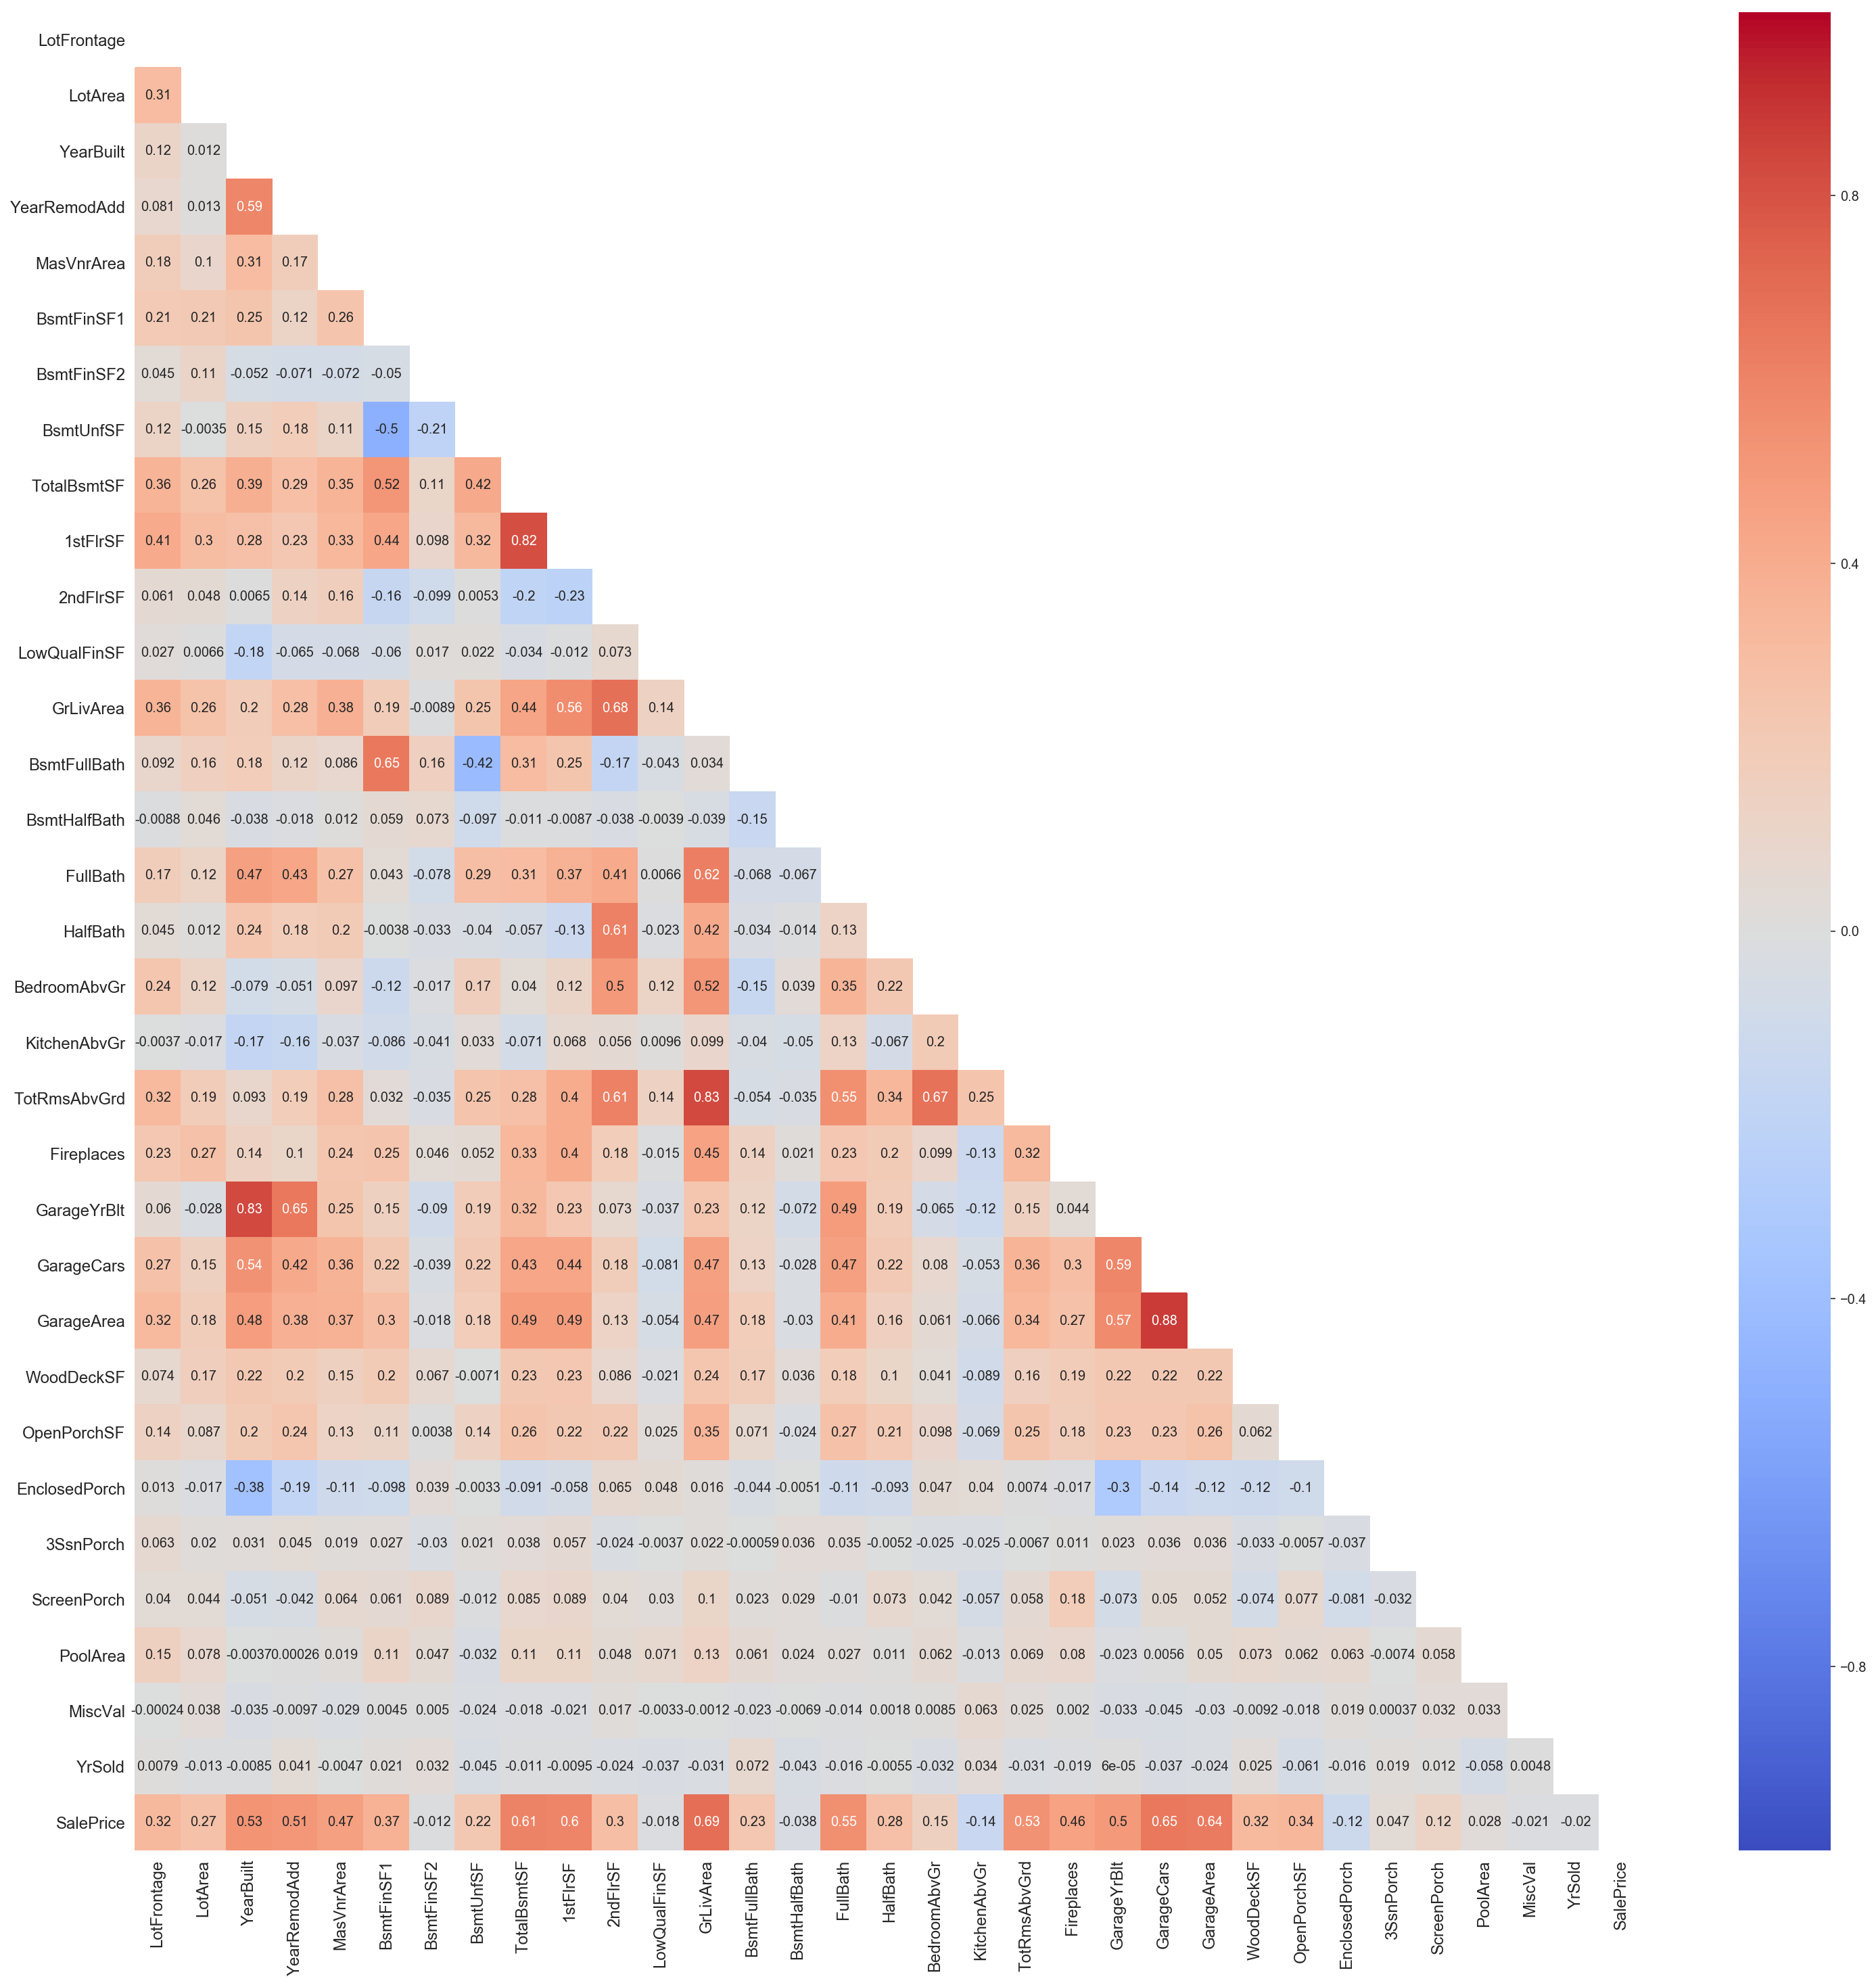

In [63]:
fig, ax = plt.subplots(figsize=(25,25))

corr = house[num_raw].corr()

# Masking the upper triangle
mask = np.zeros_like(corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True

ax = sns.heatmap(corr, mask=mask, ax=ax, cmap='coolwarm',cbar=True,
                 annot=True,annot_kws={"size": 10},
                 vmin=-1, vmax=1)

ax.set_xticklabels(ax.xaxis.get_ticklabels(), fontsize=12)
ax.set_yticklabels(ax.yaxis.get_ticklabels(), fontsize=12)

plt.show()

Find any numerical variable that has > 0.5 correlation with SalePrice. 

In [64]:
corr_to_SalePrice = []

for elem in num_raw:
    corr_SalePrice = house[elem].corr(house['SalePrice'])
    
    if abs(corr_SalePrice) != 1 and abs(corr_SalePrice) >= 0.3:
        corr_to_SalePrice.append(elem)
        
print('"SalePrice" has greater than 0.5 correlation with : ')
print(corr_to_SalePrice)

"SalePrice" has greater than 0.5 correlation with : 
['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']


Find any numerical variable pair that has > 0.3 correlation with each other and create a dictionary.

In [65]:
dict = {}

# Iterate through all rows of correlation matrix except for 'SalePrice'
for i in range(len(num_raw)-1): 
    values = []
    
    # Iterate through all columns of correlation matrix.
    for j in range(len(num_raw)):
        
        # We want to access only the lower half of the matrix
        lower = np.tril(corr)
        corr_value = lower[i][j]
        
        # If the correlation value is greater than 0.3, the column name is appended to the value list.
        if abs(corr_value) != 1 and abs(corr_value) > 0.3:
            values.append(corr.index[j])
            dict[corr.index[i]] = values


for key in corr_to_SalePrice:

    # We are only interested in the variables that are highly correlated to 'SalePrice'
    if key in dict:
        val = dict[key]
        print('num var : ', key)
        print('correlated to : ', val)
        print('------------------------------------------')

num var :  YearRemodAdd
correlated to :  ['YearBuilt']
------------------------------------------
num var :  MasVnrArea
correlated to :  ['YearBuilt']
------------------------------------------
num var :  TotalBsmtSF
correlated to :  ['LotFrontage', 'YearBuilt', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF']
------------------------------------------
num var :  1stFlrSF
correlated to :  ['LotFrontage', 'MasVnrArea', 'BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF']
------------------------------------------
num var :  GrLivArea
correlated to :  ['LotFrontage', 'MasVnrArea', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF']
------------------------------------------
num var :  FullBath
correlated to :  ['YearBuilt', 'YearRemodAdd', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea']
------------------------------------------
num var :  TotRmsAbvGrd
correlated to :  ['LotFrontage', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr']
------------------------------------------
num var :  F

From above, it is clear that some correlation happened by chance, so we remove those and create a new dictionary, {num_HiCorr}

In [66]:
num_HiCorr = {'YearRemodAdd' : ['YearBuilt'], 
              'TotalBsmtSF' : ['BsmtFinSF1', 'BsmtUnfSF'],
              '1stFlrSF' : ['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF'],
              'GrLivArea' : ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'],
              'FullBath' : ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'],
              'TotRmsAbvGrd' :  ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr'],
              'Fireplaces' :  ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd'],
              'GarageYrBlt':  ['YearBuilt', 'YearRemodAdd'],
              'GarageArea':  ['GarageCars'],
             }

In [67]:
corr_to_SalePrice = ['LotFrontage', 'YearBuilt', 'YearRemodAdd', 'MasVnrArea', 'BsmtFinSF1', 
                     'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 
                     'TotRmsAbvGrd', 'Fireplaces', 'GarageYrBlt', 'GarageCars', 'GarageArea', 
                     'WoodDeckSF', 'OpenPorchSF']

### Examine numerical features that show high correlation (>0.3) with SalePrice.

### LotFrontage vs SalePrice

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "LotFrontage" and "SalePrice" :  0.3235651559960338
-----------------------------------------------------------


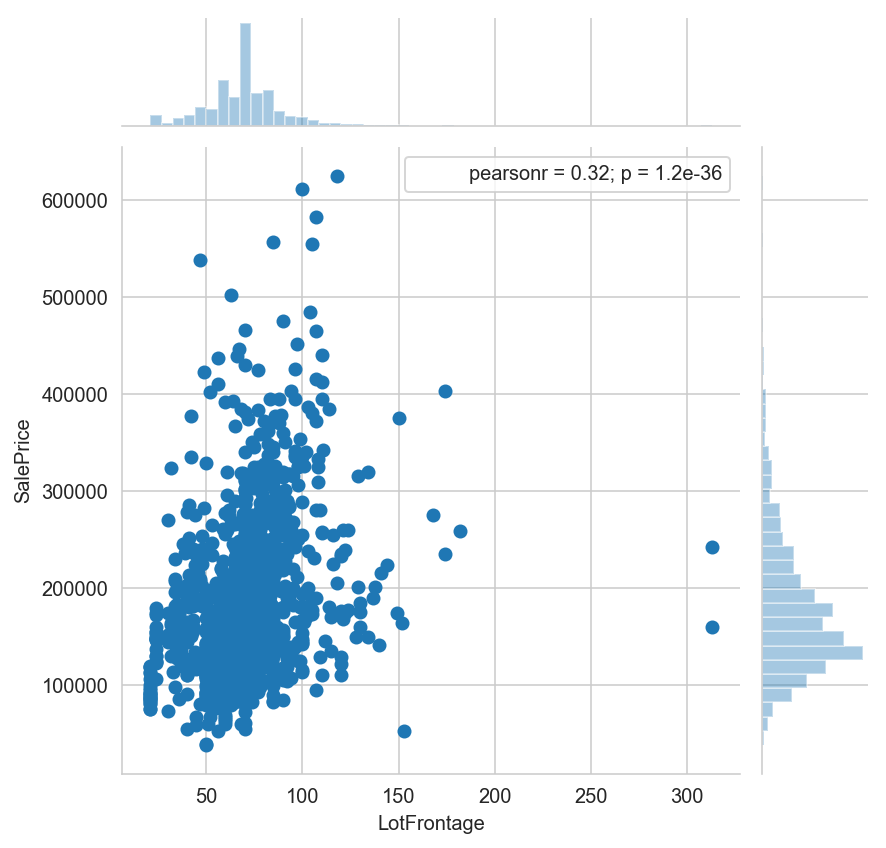

In [68]:
plot = sns.jointplot(x='LotFrontage',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "LotFrontage" and "SalePrice" : ', house['LotFrontage'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

In [69]:
house_outlier = house[(house['LotFrontage'] >= 300) | ((house['LotFrontage'] >= 150) & (house['SalePrice'] < 100000))]
house = house.drop(house_outlier.index)

print('Correlation between "LotFrontage" and "SalePrice" : ', house['LotFrontage'].corr(house['SalePrice']))

Correlation between "LotFrontage" and "SalePrice" :  0.3583042044019992


### Property/ Garage Age vs SalePrice

['YearBuilt', 'YearRemodAdd', 'GarageYrBlt']


Since 'year' is categorical, we will examine the number of years since the property was built.

#### Age of the property since first built

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "PropAge" and "SalePrice" :  -0.5298957525425285
-----------------------------------------------------------


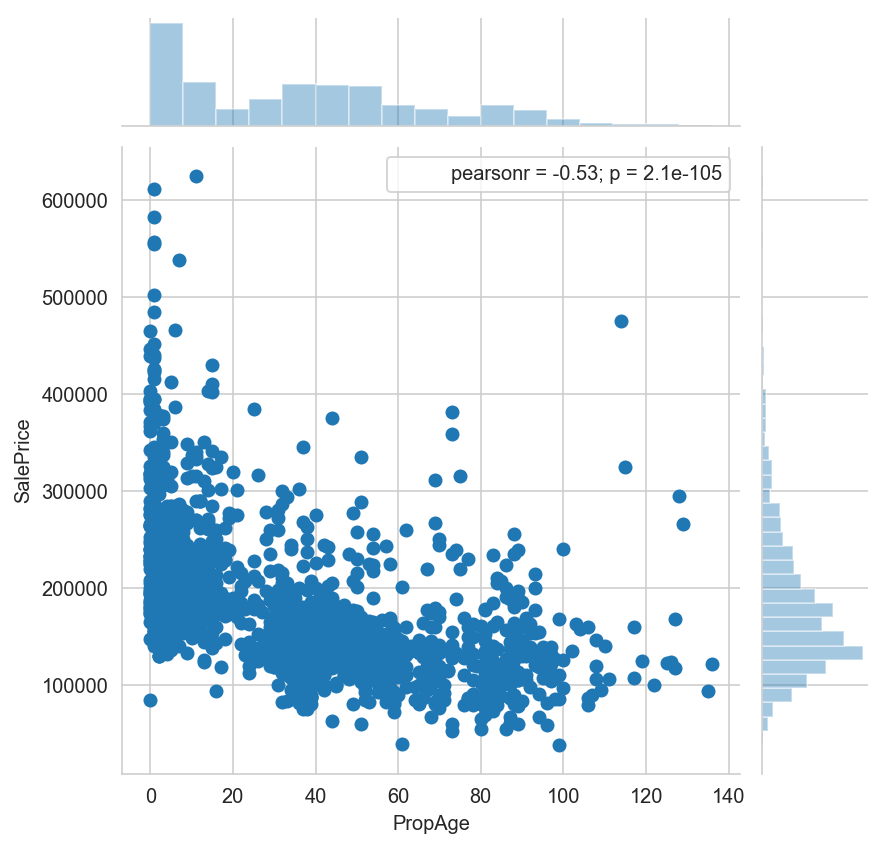

In [70]:
# Create a column with house age since first built
house['PropAge']=house.YrSold - house.YearBuilt

plot = sns.jointplot(x='PropAge',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "PropAge" and "SalePrice" : ', house['PropAge'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

In [71]:
PropAge_outlier = house[(house['PropAge'] >= 110) & (house['SalePrice'] > 200000)]
house = house.drop(PropAge_outlier.index)

print('Correlation between "PropAge" and "SalePrice" : ', house['PropAge'].corr(house['SalePrice']))

Correlation between "PropAge" and "SalePrice" :  -0.5562697413809378


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


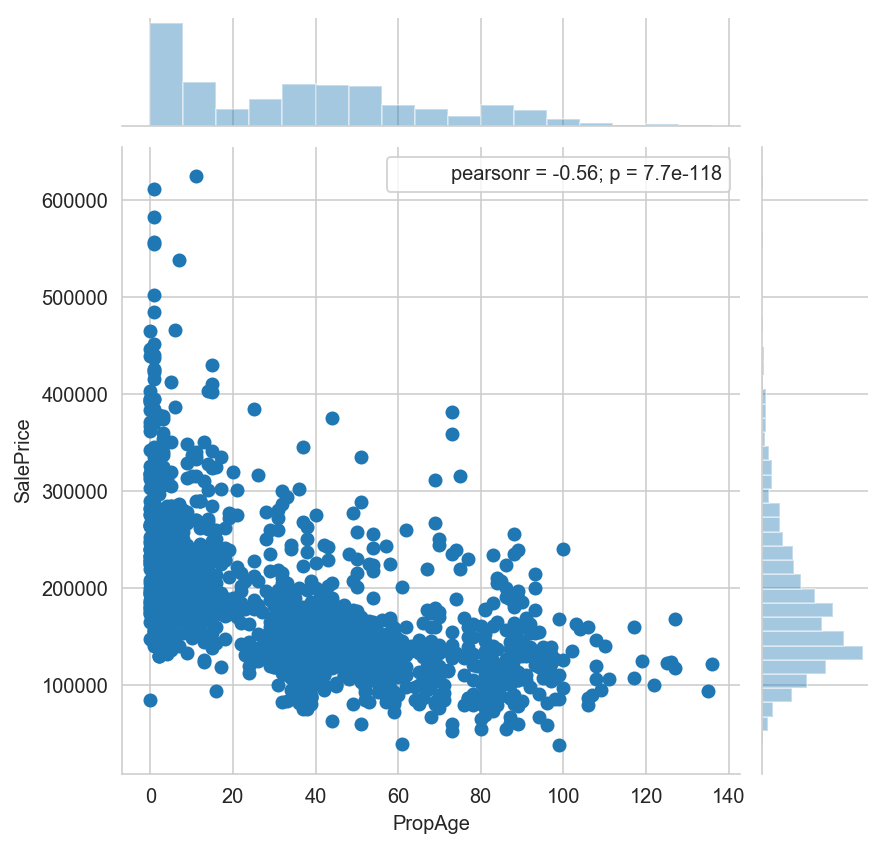

In [72]:
plot = sns.jointplot(x='PropAge',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

#### Age of the property since remodelled

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "PropRemodAge" and "SalePrice" :  -0.5163550558998798
-----------------------------------------------------------


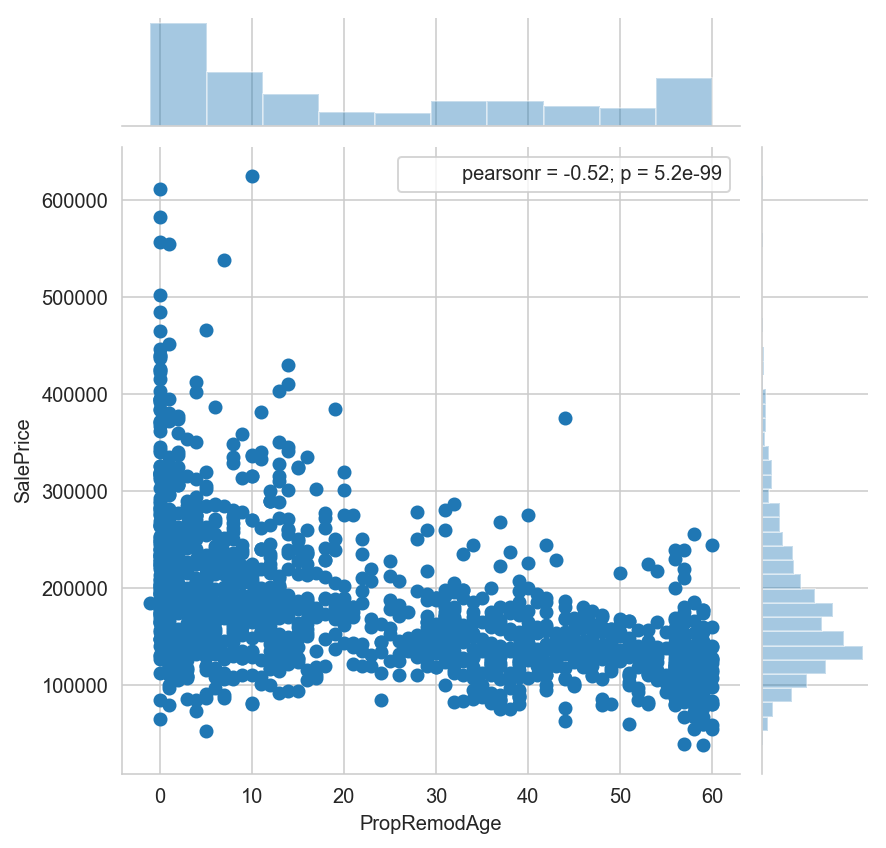

In [73]:
# Create a column with house age since remodelled
house['PropRemodAge']=house.YrSold - house.YearRemodAdd

plot = sns.jointplot(x='PropRemodAge', y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "PropRemodAge" and "SalePrice" : ', house['PropRemodAge'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

In [74]:
PropRemodAge_outlier = house[((house['PropRemodAge'] >= 40) & (house['SalePrice'] > 300000)) | ((house['PropRemodAge'] >= 5) & (house['SalePrice'] > 600000))]
house = house.drop(PropRemodAge_outlier.index)

print('Correlation between "PropRemodAge" and "SalePrice" : ', house['PropRemodAge'].corr(house['SalePrice']))

Correlation between "PropRemodAge" and "SalePrice" :  -0.5234078689058483


#### Age of the garage since built

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "GarageAge" and "SalePrice" :  -0.5075026030954701
-----------------------------------------------------------


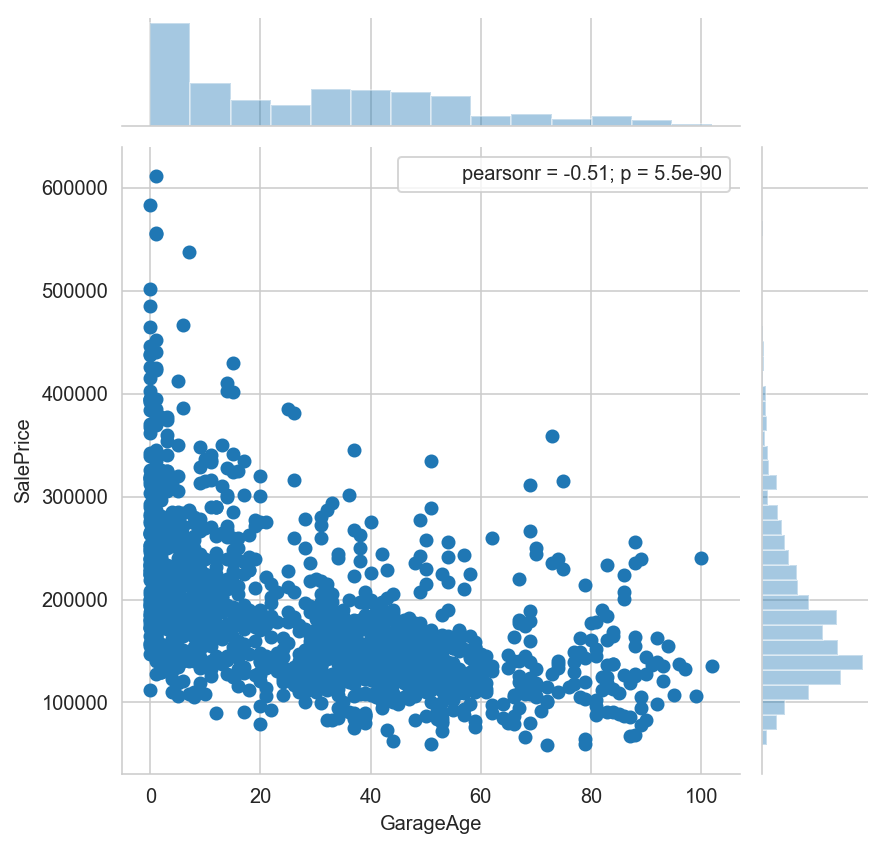

In [75]:
house['GarageAge']=house.YrSold - house.GarageYrBlt

plot = sns.jointplot(x='GarageAge', y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "GarageAge" and "SalePrice" : ', house['GarageAge'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

### MasVnrArea vs SalePrice

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "MasVnrArea" and "SalePrice" :  0.4643481877551164
-----------------------------------------------------------


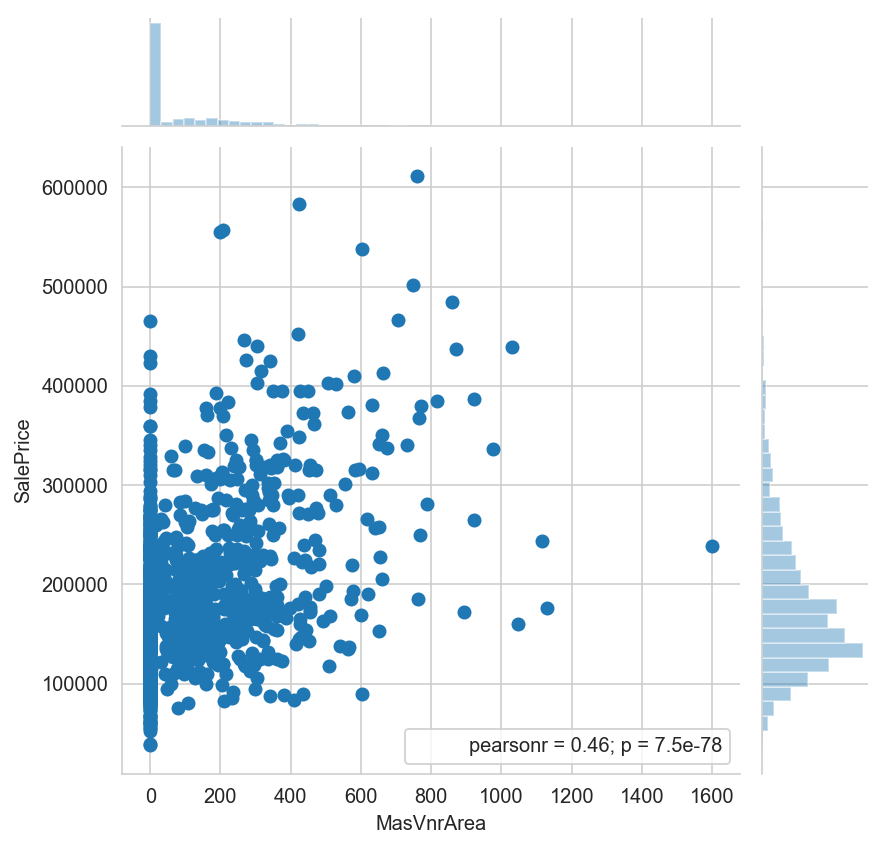

In [76]:
plot = sns.jointplot(x='MasVnrArea', y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "MasVnrArea" and "SalePrice" : ', house['MasVnrArea'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

In [77]:
MasVnrArea_outlier = house[((house['MasVnrArea'] >= 1400) & (house['SalePrice'] < 300000))]
house = house.drop(MasVnrArea_outlier.index)

print('Correlation between "PropRemodAge" and "SalePrice" : ', house['MasVnrArea'].corr(house['SalePrice']))

Correlation between "PropRemodAge" and "SalePrice" :  0.47189800120074404


### HouseFloorArea vs SalePrice

['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 
'FullBath', 'TotRmsAbvGrd', 'Fireplaces', 'GarageCars', 'GarageArea']

Those features are indicators of house floor areas and they are inter-related to each other. We will check which feature is more correlated to SalePrice.

In [78]:
area_indicators = ['BsmtFinSF1', 'TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'TotRmsAbvGrd', 'Fireplaces']


dict_area = {}
for elem in area_indicators:
    val_area = house[elem].corr(house['SalePrice'])
    dict_area[elem] = val_area

df_area_corr = pd.DataFrame.from_dict(dict_area, orient='index')
df_area_corr.sort_values(by=df_area_corr.columns[0], ascending=False)

0
GrLivArea     0.701556
TotalBsmtSF   0.642277
1stFlrSF      0.615864
FullBath      0.549693
TotRmsAbvGrd  0.526223
Fireplaces    0.459928
BsmtFinSF1    0.395104
2ndFlrSF      0.278958

From this, we will look at the 'GrLivArea' and 'TotalBsmtSF'. The other area indicators are correlated to those two, so we'll need to drop them.

corr('GrLivArea', 'SalePrice') = 0.70 and
corr('TotalBsmtSF', 'SalePrice') = 0.64

We will combine 'GrLivArea' and 'TotalBsmtSF' and see if it goves better correlation to 'SalePrice'

#### Combine 'GrLivArea', 'TotalBsmtSF'

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


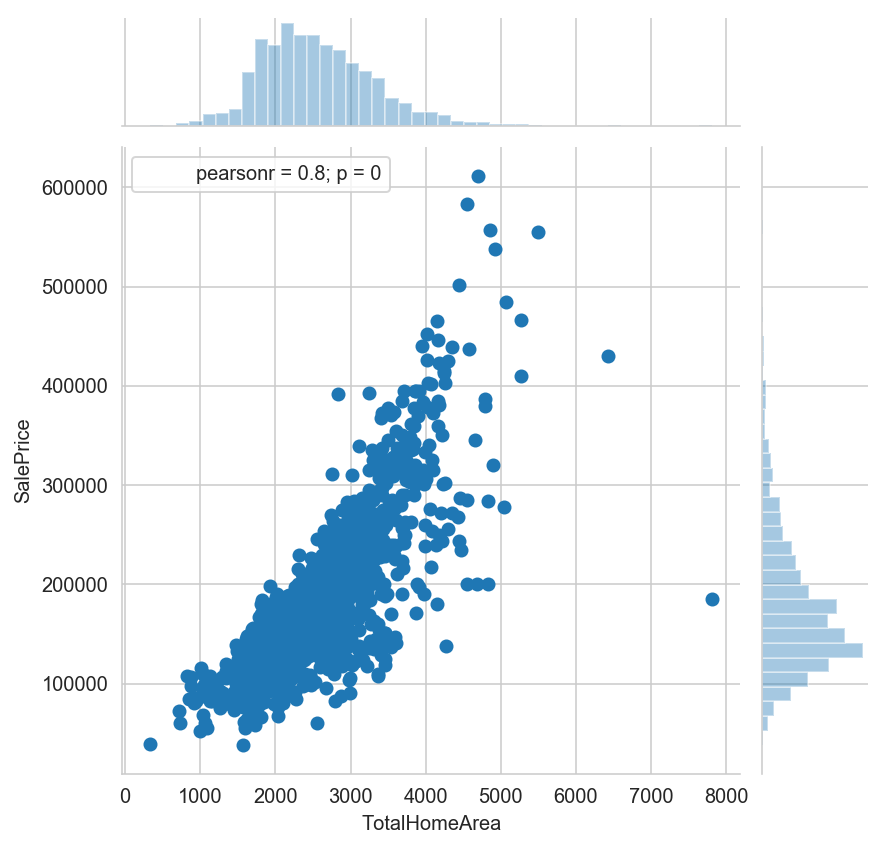

In [79]:
# Create a column with above ground and basement areas combined
house['TotalHomeArea'] = house.GrLivArea + house.TotalBsmtSF

plot = sns.jointplot(x='TotalHomeArea',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalHomeArea" and "SalePrice" :  0.8037076962872476
-----------------------------------------------------------


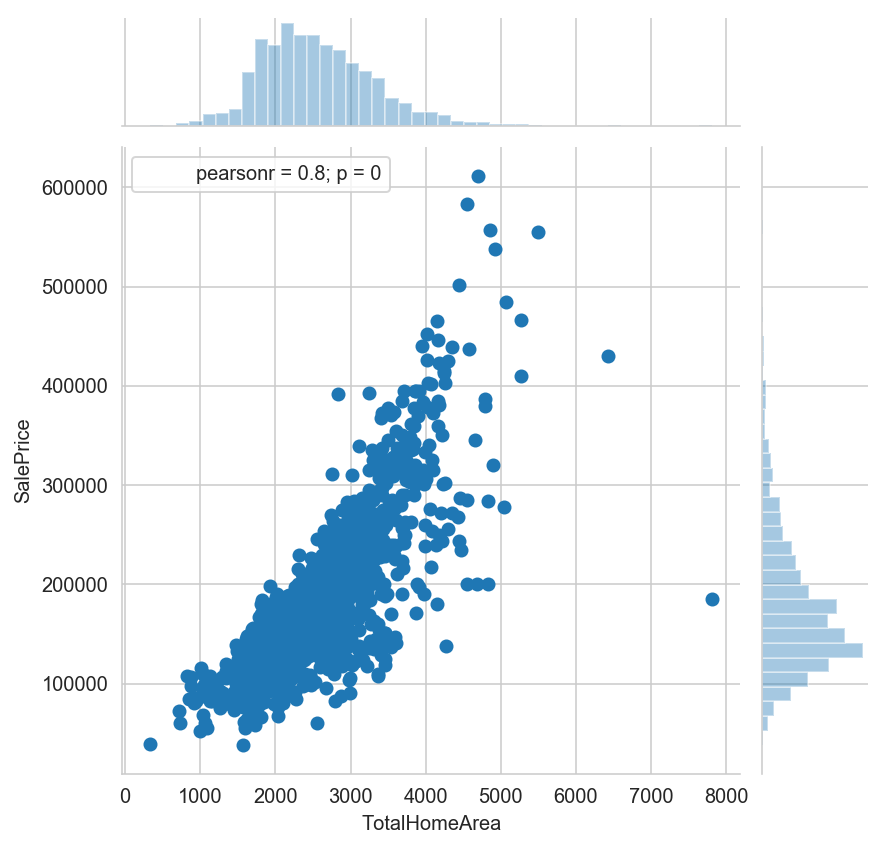

In [80]:
# Create a column with above ground and basement areas combined
house['TotalHomeArea'] = house.GrLivArea + house.TotalBsmtSF

plot = sns.jointplot(x='TotalHomeArea',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalHomeArea" and "SalePrice" : ', house['TotalHomeArea'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

In [81]:
TotalHomeArea_outlier = house[(house['TotalHomeArea'] >= 6000)]
house = house.drop(TotalHomeArea_outlier.index)

print('Correlation between "TotalHomeArea" and "SalePrice" : ', house['TotalHomeArea'].corr(house['SalePrice']))

Correlation between "TotalHomeArea" and "SalePrice" :  0.8158133047428187


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


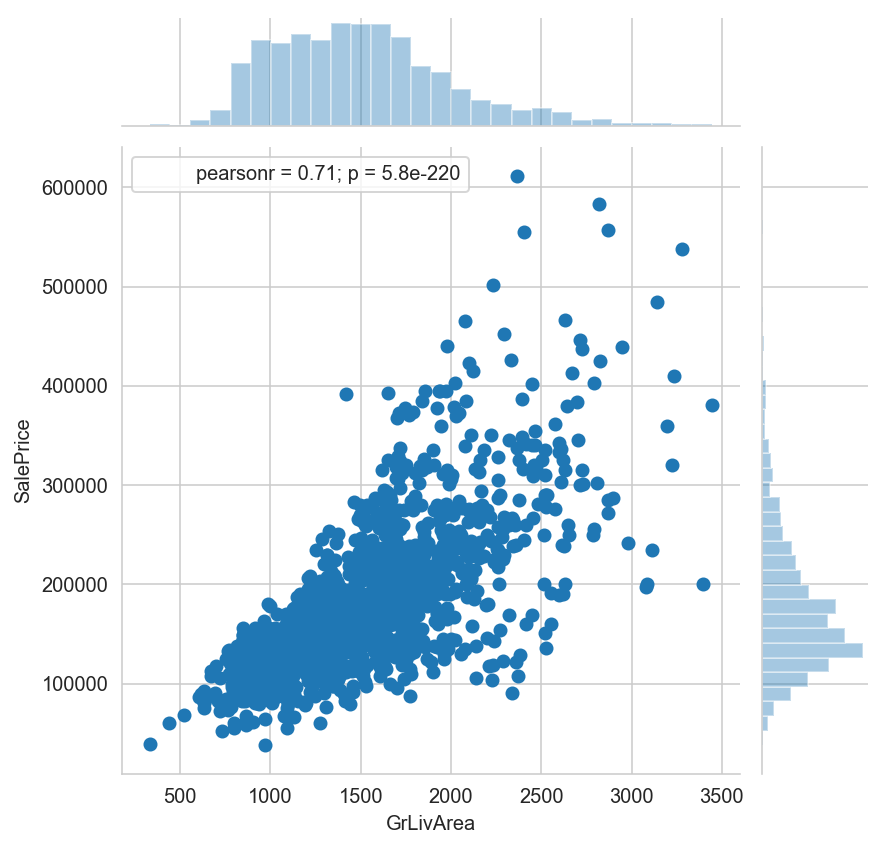

In [82]:
plot = sns.jointplot(x='GrLivArea',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

### GarageSpace vs SalePrice

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))
C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


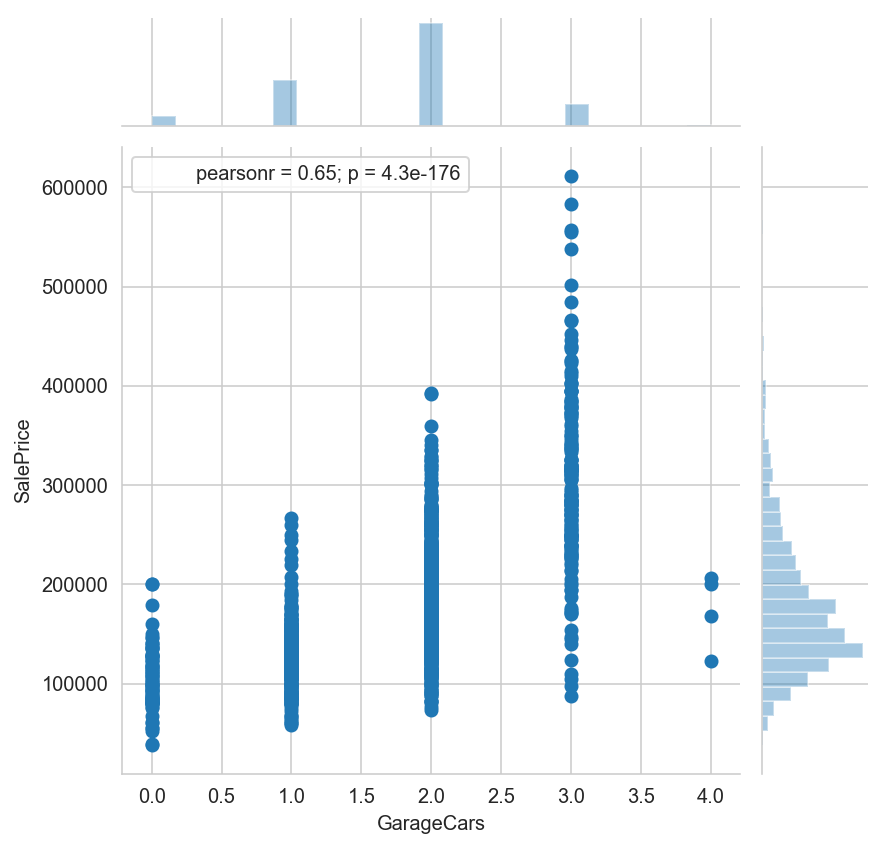

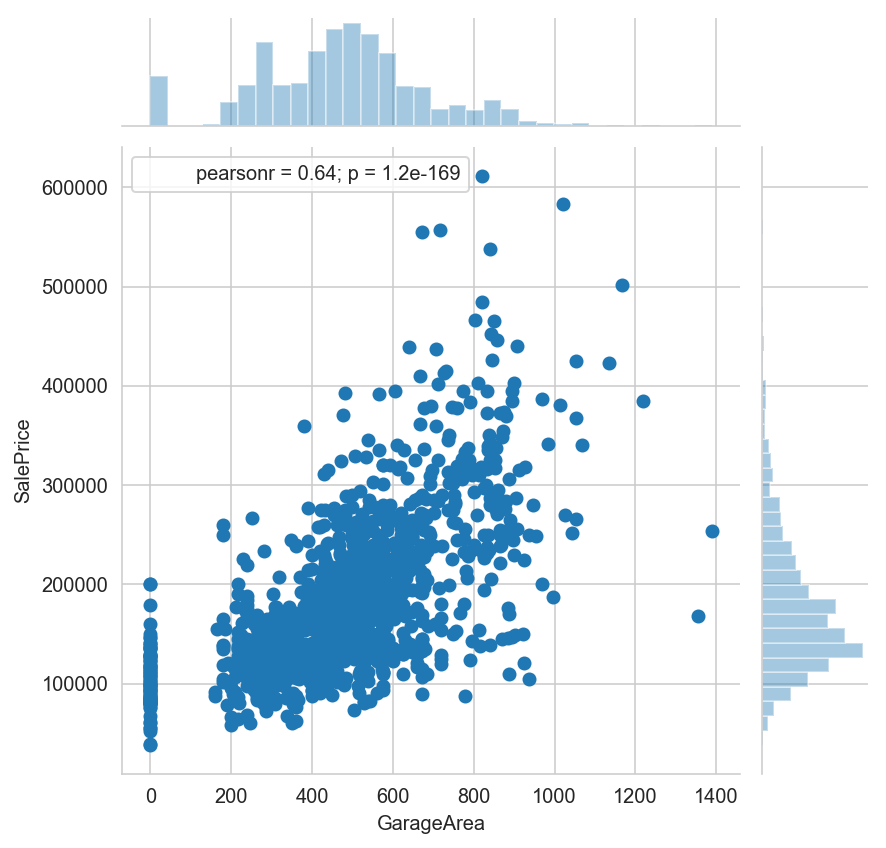

In [83]:
plot1 = sns.jointplot(x='GarageCars',y='SalePrice', data=house)
plot1.annotate(stats.pearsonr)

plot2 = sns.jointplot(x='GarageArea',y='SalePrice', data=house)
plot2.annotate(stats.pearsonr)

We will use 'GarageArea' as the indicator as it seems 'GarageCars' show a wider range of house pricing as the size of garage increases.

In [84]:
# There are two properties that have greater than 1300 sf @ low price. These are outliers, so we remove them.
GarageArea_outlier = house[house['GarageArea'] >= 1300]
house = house.drop(GarageArea_outlier.index)

print('Correlation between "GarageArea" and "SalePrice" : ', house['GarageArea'].corr(house['SalePrice']))

Correlation between "GarageArea" and "SalePrice" :  0.6510667306455625


### WoodDeckSF vs SalePrice

In [85]:
num_HiCorr = {'YearRemodAdd' : ['YearBuilt'], 
              'TotalBsmtSF' : ['BsmtFinSF1', 'BsmtUnfSF'],
              '1stFlrSF' : ['BsmtFinSF1', 'BsmtUnfSF', 'TotalBsmtSF'],
              'GrLivArea' : ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF'],
              'FullBath' : ['TotalBsmtSF', '1stFlrSF', '2ndFlrSF', 'GrLivArea'],
              'TotRmsAbvGrd' :  ['1stFlrSF', '2ndFlrSF', 'GrLivArea', 'FullBath', 'HalfBath', 'BedroomAbvGr'],
              'Fireplaces' :  ['TotalBsmtSF', '1stFlrSF', 'GrLivArea', 'TotRmsAbvGrd'],
              'GarageYrBlt':  ['YearBuilt', 'YearRemodAdd'],
              'GarageArea':  ['GarageCars'],
             }

corr_to_SalePrice = ['GarageCars', 'GarageArea', 
                     'WoodDeckSF', 'OpenPorchSF']

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


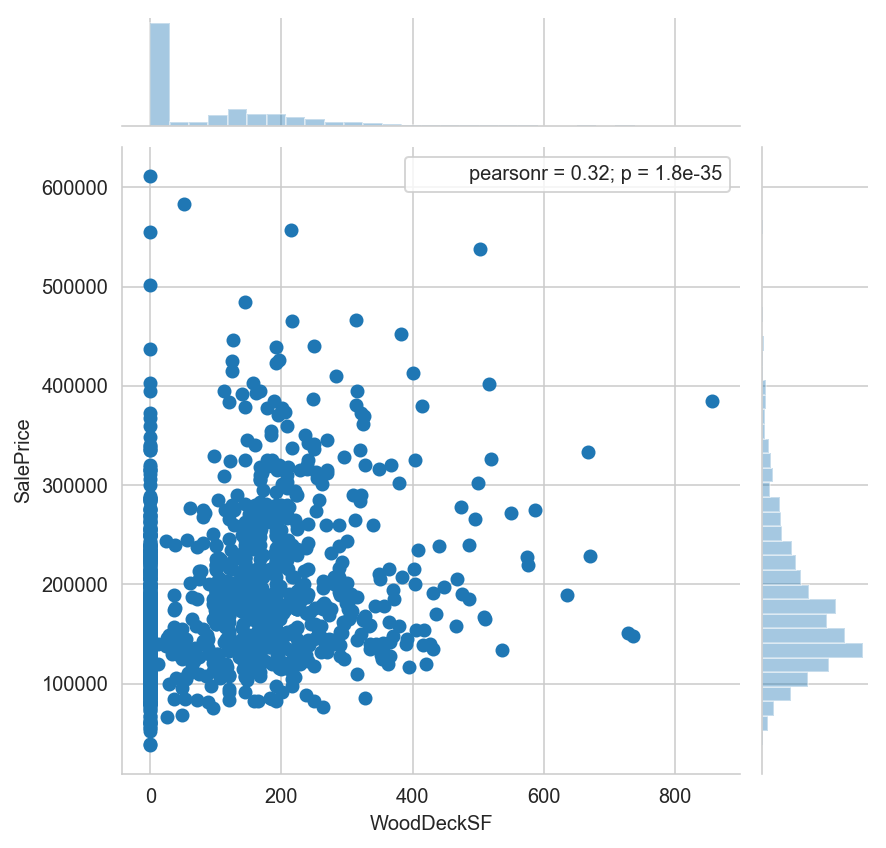

In [86]:
plot = sns.jointplot(x='WoodDeckSF',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

In [87]:
# There are two properties that have greater than 1300 sf @ low price. These are outliers, so we remove them.
GarageArea_outlier = house[house['GarageArea'] >= 1300]
house = house.drop(GarageArea_outlier.index)

print('Correlation between "GarageArea" and "SalePrice" : ', house['GarageArea'].corr(house['SalePrice']))

Correlation between "GarageArea" and "SalePrice" :  0.6510667306455625


### PorchArea vs SalePrice

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "OpenPorchSF" and "SalePrice" :  0.3432514285113977
-----------------------------------------------------------


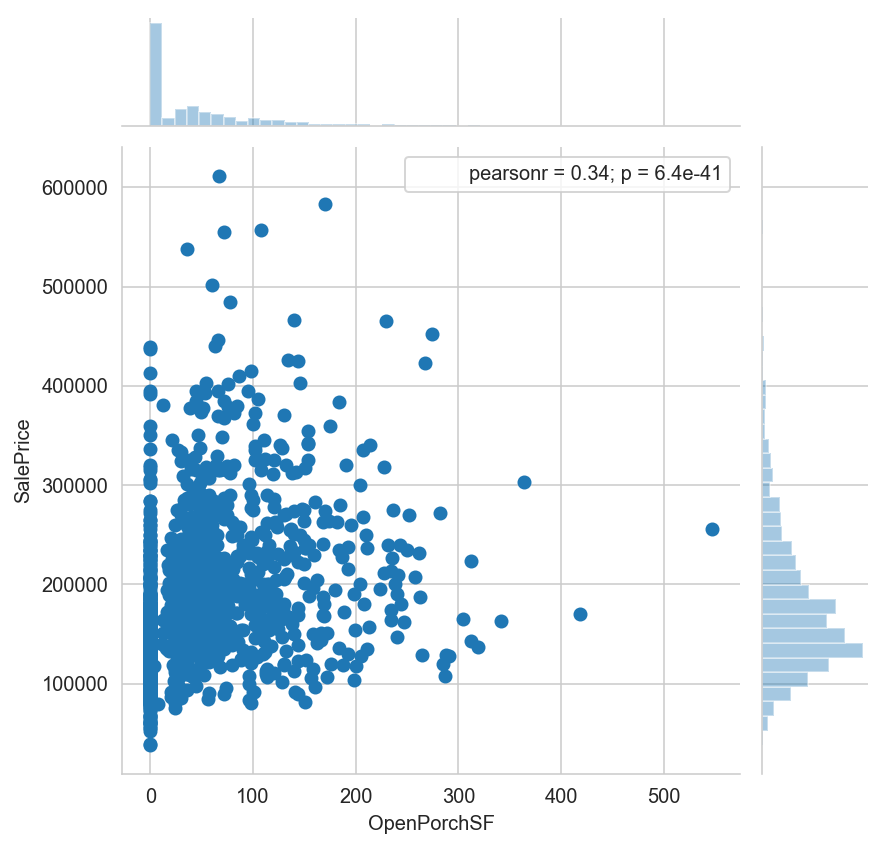

In [88]:
house['OpenPorchSF'] = house.OpenPorchSF

plot = sns.jointplot(x='OpenPorchSF',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "OpenPorchSF" and "SalePrice" : ', house['OpenPorchSF'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

In [89]:
OpenPorchSF_outlier = house[house['OpenPorchSF'] >= 400]
house = house.drop(OpenPorchSF_outlier.index)

print('Correlation between "OpenPorchSF" and "SalePrice" : ', house['OpenPorchSF'].corr(house['SalePrice']))

Correlation between "OpenPorchSF" and "SalePrice" :  0.35045308423336075


#### Combine all Porches and see if it gives better correlation with "SalePrice"

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


Correlation between "TotalPorch" and "SalePrice" :  0.16076216092270745
-----------------------------------------------------------


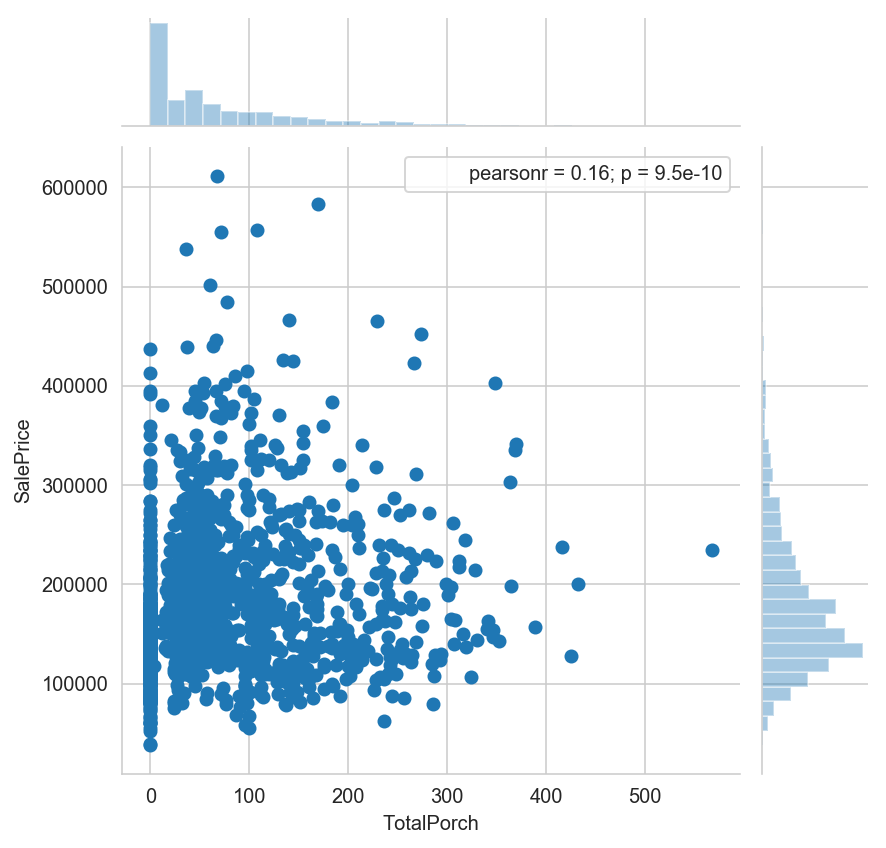

In [90]:
# Create a column with total porch areas 
# Note '3SsnPorch' and 'ScreenPorch' are not included as they are cosidered a part of enclosed porch.

house['TotalPorch'] = house.OpenPorchSF + house.EnclosedPorch

plot = sns.jointplot(x='TotalPorch',y='SalePrice', data=house)
plot.annotate(stats.pearsonr)

print('Correlation between "TotalPorch" and "SalePrice" : ', house['TotalPorch'].corr(house['SalePrice']))
print('-----------------------------------------------------------')

By combining open and enclosed porches, the result is worse than open porch only. 

From above EDS, we choose numerical variables :
['LotFrontage', 'PropAge', 'MasVnrArea', 'TotalHomeArea', 'GarageArea', 'OpenPorchSF']

In [91]:
num = ['LotFrontage', 'PropAge', 'MasVnrArea', 'TotalHomeArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF']

## EDA on Categorical Features

In [92]:
# Create a list of categorical variables



# Initialise categorical feature list
cat_raw = []

for elem in house.columns:
    if elem not in num_raw:
        cat_raw.append(elem)

print(cat_raw)

['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'MoSold', 'SaleType', 'SaleCondition', 'PropAge', 'PropRemodAge', 'GarageAge', 'TotalHomeArea', 'TotalPorch']


In [93]:
# remove some non-categorical features

non_cat = ['MoSold', 'PropAge', 'PropRemAge', 'PropRemodAge', 'GarageAge', 'TotalHomeArea', 'TotalPorch']

for elem in non_cat:
    if elem in cat_raw:
        cat_raw.remove(elem)

cat_raw.append('SalePrice')    
print('Categorical features : ', len(cat_raw))
print('--------------------------------------------------------------------------')
print(cat_raw)

Categorical features :  43
--------------------------------------------------------------------------
['MSSubClass', 'MSZoning', 'Street', 'LotShape', 'LandContour', 'Utilities', 'LotConfig', 'LandSlope', 'Neighborhood', 'Condition1', 'Condition2', 'BldgType', 'HouseStyle', 'OverallQual', 'OverallCond', 'RoofStyle', 'RoofMatl', 'Exterior1st', 'Exterior2nd', 'MasVnrType', 'ExterQual', 'ExterCond', 'Foundation', 'BsmtQual', 'BsmtCond', 'BsmtExposure', 'BsmtFinType1', 'BsmtFinType2', 'Heating', 'HeatingQC', 'CentralAir', 'Electrical', 'KitchenQual', 'Functional', 'FireplaceQu', 'GarageType', 'GarageFinish', 'GarageQual', 'GarageCond', 'PavedDrive', 'SaleType', 'SaleCondition', 'SalePrice']


In [94]:
fig, axes = plt.subplots(42, 2, figsize = (15,270))

for i in range(len(cat_raw)):

    if cat_raw[i] != 'SalePrice':
        countplot = sns.countplot(data = house, x = cat_raw[i], ax=axes[i][0])
        countplot.set_xticklabels(labels = house[cat_raw[i]].unique(), rotation=40, fontdict = {'fontsize': 10})
        
        boxplot = sns.boxplot(data = house, x = cat_raw[i], y = 'SalePrice', ax=axes[i][1])
        boxplot.set_xticklabels(labels = house[cat_raw[i]].unique(), rotation=40, fontdict = {'fontsize': 10})



From the countplot above, we can see 'Neighborhood', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'GarageFinish' may be usable features.

In [95]:
cat = ['Neighborhood', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'GarageFinish']

### Fixed features selected by EDA & Model fitting

In [96]:
features = num + cat + ['SalePrice']
print(features)

['LotFrontage', 'PropAge', 'MasVnrArea', 'TotalHomeArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Neighborhood', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'GarageFinish', 'SalePrice']


Choose fixed features & create a dataframe with only the fixed features

In [97]:
fixed_fts = ['LotFrontage', 'PropAge', 'MasVnrArea',  'TotalHomeArea','GarageArea', 
             'WoodDeckSF', 'OpenPorchSF',  'Neighborhood', 'BsmtFinType1', 'GarageFinish', 
             'SalePrice']

In [98]:
house_fixed = house[fixed_fts]
house_fixed.shape
house_fixed.dtypes

LotFrontage      float64
PropAge            int64
MasVnrArea       float64
TotalHomeArea      int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
Neighborhood      object
BsmtFinType1      object
GarageFinish      object
SalePrice          int64
dtype: object

In [99]:
# Dummify all the categorical data
house_fixed_dummied = pd.get_dummies(house_fixed, drop_first=True) 

In [100]:
house_fixed_dummied.head()

LotFrontage  PropAge  MasVnrArea  TotalHomeArea  GarageArea  WoodDeckSF  \
0         65.0        5       196.0           2566         548           0   
1         80.0       31         0.0           2524         460         298   
2         68.0        7       162.0           2706         608           0   
3         60.0       91         0.0           2473         642           0   
4         84.0        8       350.0           3343         836         192   

   OpenPorchSF  SalePrice  Neighborhood_Blueste  Neighborhood_BrDale  ...  \
0           61     208500                     0                    0  ...   
1            0     181500                     0                    0  ...   
2           42     223500                     0                    0  ...   
3           35     140000                     0                    0  ...   
4           84     250000                     0                    0  ...   

   Neighborhood_Veenker  BsmtFinType1_BLQ  BsmtFinType1_GLQ  BsmtFinType1_LwQ  \
0                     0                 0                 1                 0   
1                     1                 0                 0                 0   
2                     0                 0                 1                 0   
3                     0                 0                 0                 0   
4                     0                 0                 1                 0   

   BsmtFinType1_Rec  BsmtFinType1_Unf  BsmtFinType1_not_avail  \
0                 0                 0                       0   
1                 0                 0                       0   
2                 0                 0                       0   
3                 0                 0                       0   
4                 0                 0                       0   

   GarageFinish_RFn  GarageFinish_Unf  GarageFinish_not_avail  
0                 1                 0                       0  
1                 1                 0                       0  
2                 1                 0                       0  
3                 0                 1                       0  
4                 1                 0                       0  

[5 rows x 41 columns]

#### Train & Test Model with all the fixed features

Intercept :  179814.61904761905
Coefficients :  [ 3.87273617e+03 -1.01629178e+04  3.41903825e+03  3.50072068e+04
  9.28235506e+03  4.13664563e+03  4.18508802e+03  3.04301206e+01
  2.57191427e+02  4.69345952e+03  1.69951631e+03  3.41681401e+03
  9.44552592e+03  9.01220266e+02  3.66263509e+03  1.66046387e+03
 -1.07116189e+03 -1.10627147e+03  8.85722876e+01  7.14971945e+02
 -6.37575663e+01  6.07942525e+03  1.41150483e+04  1.21768011e+03
  1.03971294e+03  2.91214143e+02  9.24885940e+02  6.65193946e+03
  9.21055757e+03  2.92785151e+03  4.46389586e+03 -4.00394186e+02
  4.04204511e+03 -1.96711433e+03 -1.87425721e+03 -3.39934732e+03
  2.26098732e+03 -5.63600668e+03 -6.91960973e+03 -2.09440284e+03]
Trained model score :  0.8444975353186122
Test data score :  0.8447046540763323


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


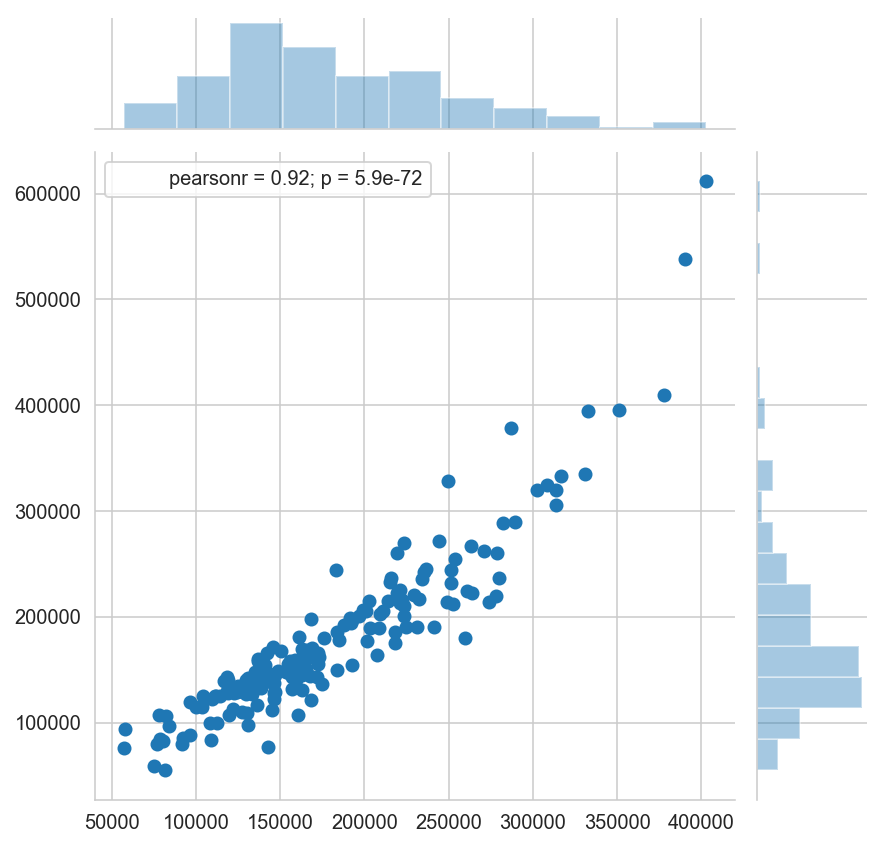

In [101]:
# Train model on pre-2010 model and test with 2010 data
#col = [c for c in house_fixed_dummied.columns if not c in ['SalePrice']]
X_train_fixed = house_fixed_dummied[house.YrSold<2010].drop(columns = ['SalePrice']).astype(float)
X_test_fixed = house_fixed_dummied[house.YrSold>2009].drop(columns = ['SalePrice']).astype(float)


# Create a dataframe for dependent variable, SalePrice
y_train_fixed = house_fixed_dummied['SalePrice'][house.YrSold<2010].values
y_test_fixed = house_fixed_dummied['SalePrice'][house.YrSold>2009].values



# Standardise the X_train and X_test features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train_fixed = ss.fit_transform(X_train_fixed)
Xs_test_fixed = ss.fit_transform(X_test_fixed)



# Linear Regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

lm = LinearRegression()
lm.fit(Xs_train_fixed, y_train_fixed)

print('Intercept : ', lm.intercept_)
print('Coefficients : ', lm.coef_)

print('Trained model score : ', lm.score(Xs_train_fixed, y_train_fixed))
print('Test data score : ', lm.score(Xs_test_fixed, y_test_fixed))

predictions_fixed = lm.predict(Xs_test_fixed)
plot_fixed_lr = sns.jointplot(predictions_fixed, y_test_fixed)
plot_fixed_lr.annotate(stats.pearsonr)

## Feature selection

Now that we have performed data cleaning, EDA and feature engineering, we will carry out feature selection. In this project, we will try the following methods.

- SelectKBest - The f-score (how informative a feature is in determining the target) will be calculated for each feature and the k top features are kept.

- Recursive Feature Elimination - It builds a model using various combination of features and evaluate how accurately such combination can predict the target. It recursively remove the features that do not contribute.

- Regularization via Lasso - Regularization is used to combat overfitting of model by penalizing coefficients which results in removing unimportant features.

In [102]:
# Train model on pre-2010 model and test with 2010 data
col = [c for c in house_fixed_dummied.columns if not c in ['SalePrice']]
X_train_fixed_df = house_fixed_dummied[col][house.YrSold<2010]
X_train_fixed = X_train_fixed_df.astype(float)

X_test_fixed_df = house_fixed_dummied[col][house.YrSold>2009]
X_test_fixed = X_test_fixed_df.astype(float)


# Create a dataframe for dependent variable, SalePrice
y_train_fixed_df = house_fixed_dummied['SalePrice'][house.YrSold<2010]
y_train_fixed = y_train_fixed_df.ravel()

y_test_fixed_df = house_fixed_dummied['SalePrice'][house.YrSold>2009]
y_test_fixed = y_test_fixed_df.ravel()


# Standardise the X_train and X_test features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train_fixed = ss.fit_transform(X_train_fixed)
Xs_test_fixed = ss.fit_transform(X_test_fixed)

# Put into DataFrame for later use
Xs_train_fixed_df = pd.DataFrame(Xs_train_fixed, columns=X_train_fixed_df.columns)
Xs_test_fixed_df = pd.DataFrame(Xs_test_fixed, columns=X_test_fixed_df.columns)


#### SelectKBest

In [139]:
from sklearn.feature_selection import SelectKBest, f_regression
X_fixed = house_fixed_dummied.drop(columns = ['SalePrice'])
y_fixed = house_fixed_dummied['SalePrice']

# Initialise skb
skb = SelectKBest(f_regression, k=5)

# Find kbest by examining the F-score
# F-scores are the test statistic for the F-test, and they represent the ratio between ..
# .. the explained and the unexplained variance
skb.fit(X_train_fixed, y_train_fixed)

kbest = pd.DataFrame({'feature_skb': X_fixed.columns.values.tolist(), 
                      'f_score': skb.scores_.tolist()}).sort_values('f_score', ascending = False)

kbest.reset_index(drop = True, inplace = True)
kbest.head()

feature_skb      f_score
0         TotalHomeArea  2472.311570
1            GarageArea   951.075805
2               PropAge   589.174047
3            MasVnrArea   362.232562
4  Neighborhood_NridgHt   314.202484

Trained model score :  0.8430830725465434
Test data score :  0.8428545447055462
Intercept :  179814.61904761905
Coefficients :  [ 34752.10410197   8870.14529001 -11033.4107344    3043.07150184
  12537.22858383   4414.38848746  -7383.15315898   4204.07213474
   4151.01389602   4180.81923696   5113.4824684   -2430.70020487
   -279.40037435   8306.73601055  -2157.46154863  -6079.32154876
   -757.86273743   4852.72018124   3444.77668292   2377.24959159
   -259.79828331  -1643.86924387    830.02937615   1811.56052509
  -1110.34739111  -1771.05479447   -360.51668697   1095.82028306
  -2748.5704629   -1753.76323097   3835.34264036   8309.5409629
    305.51118766  -2359.3931638 ]


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


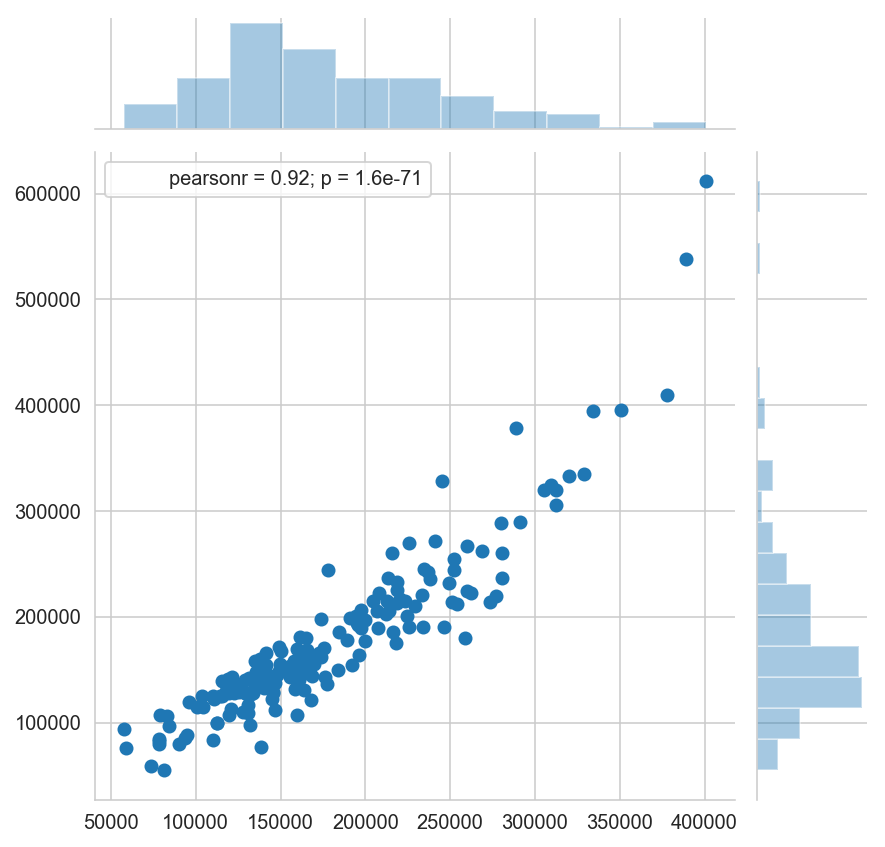

In [104]:
skb_selection = kbest.loc[kbest.f_score > 5, 'feature_skb'].tolist()


lr= LinearRegression()
model = lr.fit(Xs_train_fixed_df[skb_selection], y_train_fixed_df)
print('Trained model score : ', model.score(Xs_train_fixed_df[skb_selection], y_train_fixed_df))
print('Test data score : ', model.score(Xs_test_fixed_df[skb_selection], y_test_fixed_df))

print('Intercept : ', lr.intercept_)
print('Coefficients : ', lr.coef_)

predictions_fixed_skb = lr.predict(Xs_test_fixed_df[skb_selection])

plot_fixed_skb = sns.jointplot(predictions_fixed_skb, y_test_fixed)
plot_fixed_skb.annotate(stats.pearsonr)

The coefficients suggest an increase in the total home are by 1 sqft increases the house value by 34,752 dollars while the property age will reduce the value by 11,033 dollars per year. 

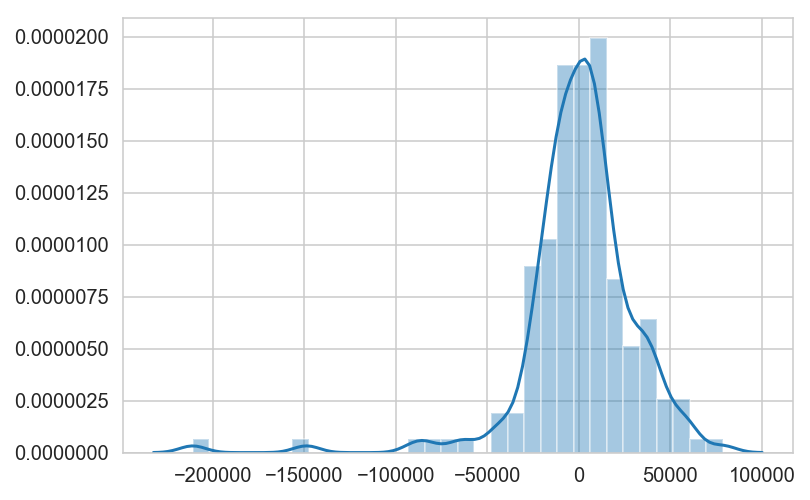

In [138]:
# Check the distribution of residuals
sns.distplot(predictions_fixed_skb - y_test_fixed)

#### Recursive Feature Elimination 

In [105]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X_fixed, y_fixed)


RFECV = pd.DataFrame({'feature_RFECV': X_fixed.columns.values.tolist(),
                      'support': selector.support_,
                      'ranking': selector.ranking_}).sort_values('ranking', ascending = True)

RFECV.reset_index(drop = True, inplace = True)
RFECV

feature_RFECV  support  ranking
0              LotFrontage     True        1
1     Neighborhood_NridgHt     True        1
2     Neighborhood_OldTown     True        1
3       Neighborhood_SWISU     True        1
4      Neighborhood_Sawyer     True        1
5     Neighborhood_SawyerW     True        1
6     Neighborhood_Somerst     True        1
7     Neighborhood_StoneBr     True        1
8     Neighborhood_NoRidge     True        1
9      Neighborhood_Timber     True        1
10        BsmtFinType1_BLQ     True        1
11        BsmtFinType1_GLQ     True        1
12        BsmtFinType1_LwQ     True        1
13        BsmtFinType1_Rec     True        1
14        BsmtFinType1_Unf     True        1
15  BsmtFinType1_not_avail     True        1
16        GarageFinish_RFn     True        1
17    Neighborhood_Veenker     True        1
18     Neighborhood_NWAmes     True        1
19    Neighborhood_NPkVill     True        1
20      Neighborhood_NAmes     True        1
21                 PropAge     True        1
22              MasVnrArea     True        1
23           TotalHomeArea     True        1
24              GarageArea     True        1
25              WoodDeckSF     True        1
26             OpenPorchSF     True        1
27    Neighborhood_Blueste     True        1
28     Neighborhood_BrDale     True        1
29    Neighborhood_BrkSide     True        1
30    Neighborhood_ClearCr     True        1
31    Neighborhood_CollgCr     True        1
32    Neighborhood_Crawfor     True        1
33    Neighborhood_Edwards     True        1
34    Neighborhood_Gilbert     True        1
35     Neighborhood_IDOTRR     True        1
36    Neighborhood_MeadowV     True        1
37    Neighborhood_Mitchel     True        1
38        GarageFinish_Unf     True        1
39  GarageFinish_not_avail     True        1

Trained model score :  0.8444975353186122
Test data score :  0.8447046540763323
Intercept :  179814.61904761905
Coefficients :  [ 3.87273617e+03  1.41150483e+04  1.21768011e+03  1.03971294e+03
  2.91214143e+02  9.24885940e+02  6.65193946e+03  9.21055757e+03
  6.07942525e+03  2.92785151e+03 -4.00394186e+02  4.04204511e+03
 -1.96711433e+03 -1.87425721e+03 -3.39934732e+03  2.26098732e+03
 -5.63600668e+03  4.46389586e+03 -6.37575663e+01  7.14971945e+02
  8.85722876e+01 -1.01629178e+04  3.41903825e+03  3.50072068e+04
  9.28235506e+03  4.13664563e+03  4.18508802e+03  3.04301206e+01
  2.57191427e+02  4.69345952e+03  1.69951631e+03  3.41681401e+03
  9.44552592e+03  9.01220266e+02  3.66263509e+03  1.66046387e+03
 -1.07116189e+03 -1.10627147e+03 -6.91960973e+03 -2.09440284e+03]


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


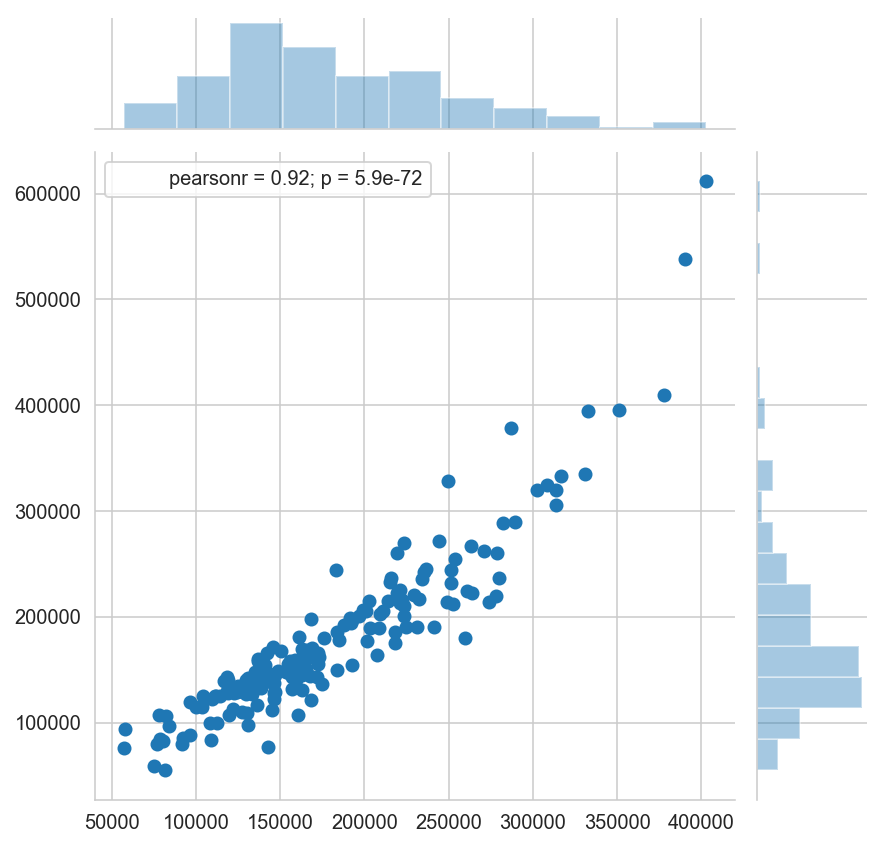

In [106]:
RFECV_selection = RFECV.loc[RFECV.ranking == 1, 'feature_RFECV'].tolist()

from sklearn.linear_model import LinearRegression

lr= LinearRegression()
model = lr.fit(Xs_train_fixed_df[RFECV_selection], y_train_fixed_df)
print('Trained model score : ', model.score(Xs_train_fixed_df[RFECV_selection], y_train_fixed_df))
print('Test data score : ', model.score(Xs_test_fixed_df[RFECV_selection], y_test_fixed_df))

print('Intercept : ', lr.intercept_)
print('Coefficients : ', lr.coef_)

predictions_fixed_RFECV = lr.predict(Xs_test_fixed_df[RFECV_selection])

plot_fixed_RFECV = sns.jointplot(predictions_fixed_RFECV, y_test_fixed)
plot_fixed_RFECV.annotate(stats.pearsonr)

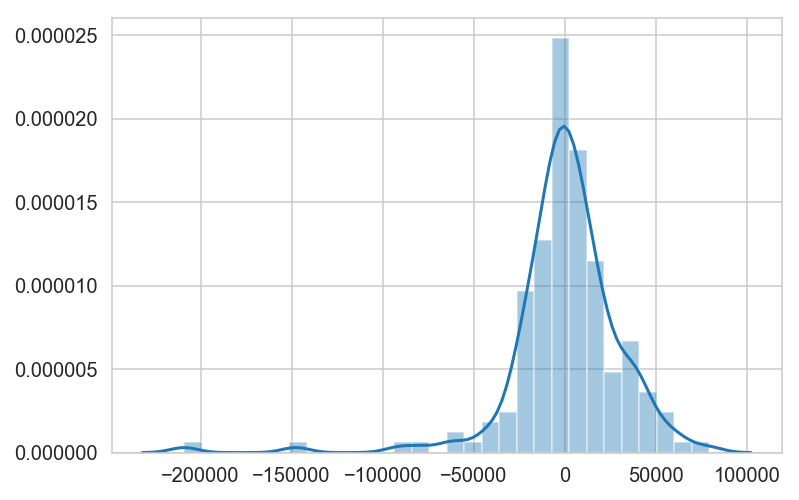

In [140]:
# Check the distribution of residuals
sns.distplot(predictions_fixed_RFECV - y_test_fixed)

#### Regularisation via Lasso

In [107]:
from sklearn.linear_model import Lasso, LassoCV

optimal_lasso = LassoCV()
optimal_lasso.fit(X_fixed, y_fixed)

# find the optimal tuning value, alpha
lasso_alpha = optimal_lasso.alpha_
lasso_coef = optimal_lasso.coef_

lasso = pd.DataFrame({'feature_lasso': X_fixed.columns.values.tolist(),
                      'coef': lasso_coef.tolist(),
                      'coef_abs': abs(lasso_coef).tolist()}).sort_values('coef_abs', ascending = False)
lasso.reset_index(drop = True, inplace = True)
    
lasso

feature_lasso        coef    coef_abs
0                  PropAge -473.295506  473.295506
1               GarageArea   61.229601   61.229601
2              OpenPorchSF   60.124755   60.124755
3            TotalHomeArea   58.570787   58.570787
4               MasVnrArea   38.215681   38.215681
5               WoodDeckSF   34.399160   34.399160
6              LotFrontage    0.000000    0.000000
7         BsmtFinType1_BLQ   -0.000000    0.000000
8      Neighborhood_Sawyer   -0.000000    0.000000
9     Neighborhood_SawyerW   -0.000000    0.000000
10    Neighborhood_Somerst    0.000000    0.000000
11    Neighborhood_StoneBr    0.000000    0.000000
12     Neighborhood_Timber    0.000000    0.000000
13    Neighborhood_Veenker    0.000000    0.000000
14        BsmtFinType1_Rec   -0.000000    0.000000
15        BsmtFinType1_GLQ    0.000000    0.000000
16        BsmtFinType1_LwQ   -0.000000    0.000000
17    Neighborhood_OldTown   -0.000000    0.000000
18        BsmtFinType1_Unf   -0.000000    0.000000
19  BsmtFinType1_not_avail    0.000000    0.000000
20        GarageFinish_RFn   -0.000000    0.000000
21        GarageFinish_Unf   -0.000000    0.000000
22      Neighborhood_SWISU   -0.000000    0.000000
23     Neighborhood_NWAmes   -0.000000    0.000000
24    Neighborhood_NridgHt    0.000000    0.000000
25    Neighborhood_NoRidge    0.000000    0.000000
26    Neighborhood_NPkVill   -0.000000    0.000000
27      Neighborhood_NAmes   -0.000000    0.000000
28    Neighborhood_Mitchel   -0.000000    0.000000
29    Neighborhood_MeadowV   -0.000000    0.000000
30     Neighborhood_IDOTRR    0.000000    0.000000
31    Neighborhood_Gilbert    0.000000    0.000000
32    Neighborhood_Edwards   -0.000000    0.000000
33    Neighborhood_Crawfor    0.000000    0.000000
34    Neighborhood_CollgCr   -0.000000    0.000000
35    Neighborhood_ClearCr    0.000000    0.000000
36    Neighborhood_BrkSide    0.000000    0.000000
37     Neighborhood_BrDale   -0.000000    0.000000
38    Neighborhood_Blueste   -0.000000    0.000000
39  GarageFinish_not_avail    0.000000    0.000000

Trained model score :  0.7739440640051367
Test data score :  0.7883399663018822
Intercept :  179814.61904761905
Coefficients :  [-16013.82813485  11985.19718127   4578.37729011  41960.01320246
   6190.9477309    4678.05943656]


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


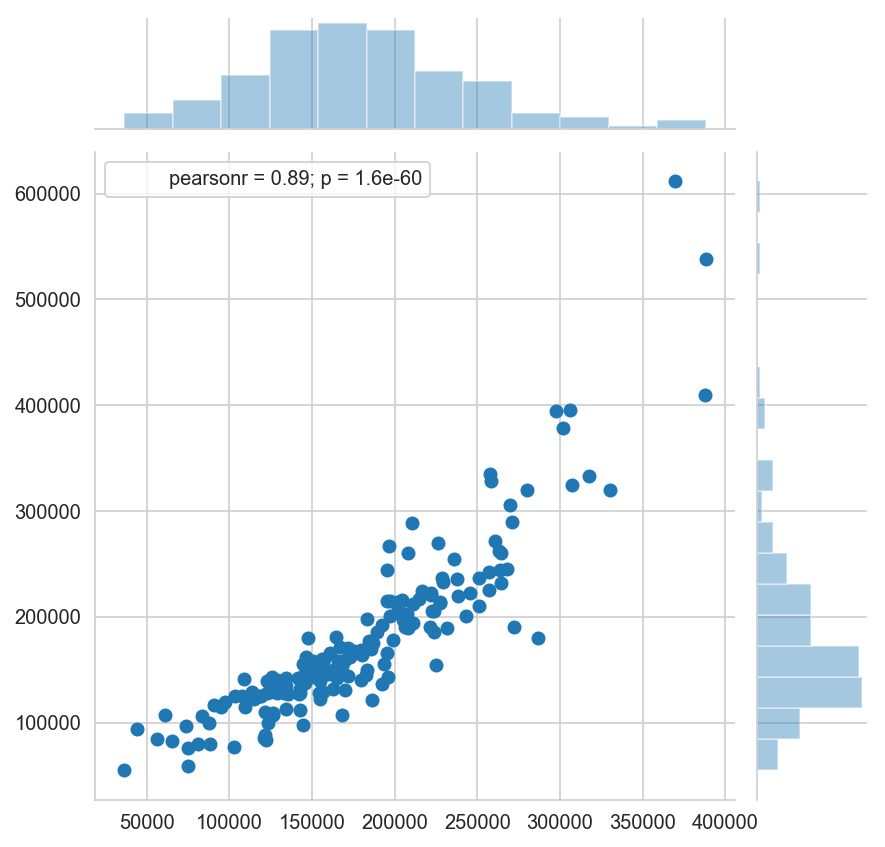

In [108]:
lasso_reg = lasso.loc[lasso.coef_abs > 0, 'feature_lasso'].tolist()

lr = LinearRegression()
lasso_model = lr.fit(Xs_train_fixed_df[lasso_reg], y_train_fixed_df)
print('Trained model score : ', lasso_model.score(Xs_train_fixed_df[lasso_reg], y_train_fixed_df))
print('Test data score : ', lasso_model.score(Xs_test_fixed_df[lasso_reg], y_test_fixed_df))

print('Intercept : ', lr.intercept_)
print('Coefficients : ', lr.coef_)

predictions_fixed_lasso = lr.predict(Xs_test_fixed_df[lasso_reg])
plot_fixed_lasso = sns.jointplot(predictions_fixed_lasso, y_test_fixed)
plot_fixed_lasso.annotate(stats.pearsonr)

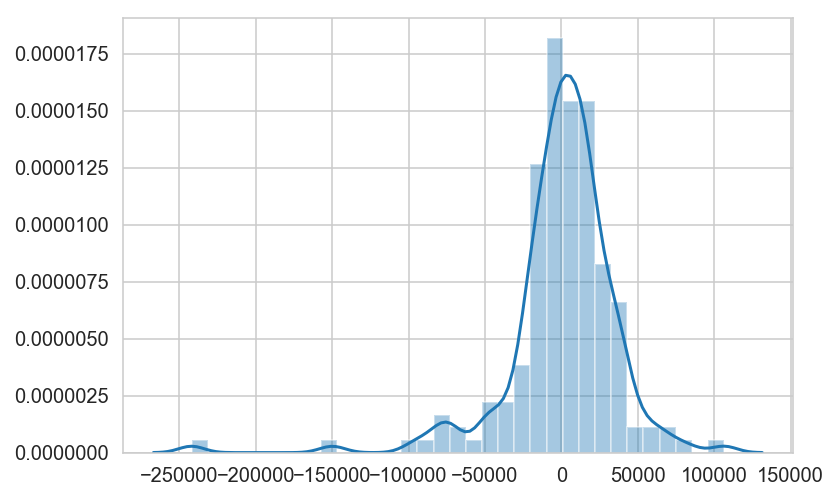

In [141]:
# Check the distribution of residuals
sns.distplot(predictions_fixed_lasso - y_test_fixed)

### Conclusion for Question 1:
It appears that that the model with fixed features, ['LotFrontage', 'PropAge', 'MasVnrArea',  'TotalHomeArea','GarageArea', 'WoodDeckSF', 'OpenPorchSF',  'Neighborhood', 'BsmtFinType1', 'GarageFinish', 'SalePrice'] gives the best prediction.


Examining the distribution plot of the residuals on all the models, they perform well for the house values less than $500,000, but they show a significant price difference at greater than such value.

<img src="http://imgur.com/l5NasQj.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 2. Determine any value of *changeable* property characteristics unexplained by the *fixed* ones.

---

Now that you have a model that estimates the price of a house based on its static characteristics, we can move forward with part 2 and 3 of the plan: what are the costs/benefits of quality, condition, and renovations?

There are two specific requirements for these estimates:
1. The estimates of effects must be in terms of dollars added or subtracted from the house value. 
2. The effects must be on the variance in price remaining from the first model.

The residuals from the first model (training and testing) represent the variance in price unexplained by the fixed characteristics. Of that variance in price remaining, how much of it can be explained by the easy-to-change aspects of the property?

---

**The goals:**
1. Evaluate the effect in dollars of the renovate-able features. 
- How would your company use this second model and its coefficients to determine whether they should buy a property or not? Explain how the company can use the two models you have built to determine if they can make money. 
- Investigate how much of the variance in price remaining is explained by these features.
- Do you trust your model? Should it be used to evaluate which properties to buy and fix up?

Previously, we chose features after performing the EDA. The features include both fixed and renovatable features.

features = ['LotFrontage', 'PropAge', 'MasVnrArea', 'TotalHomeArea', 'GarageArea', 'WoodDeckSF', 'OpenPorchSF', 'Neighborhood', 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'GarageFinish', 'SalePrice']
 
We will carry out the same procedure as Part 1. 

- First, dummify all the categorical columns 

In [109]:
reno_fts = ['LotFrontage', 'PropAge', 'MasVnrArea', 'TotalHomeArea', 'GarageArea', 
            'WoodDeckSF', 'OpenPorchSF', 'Neighborhood', 'OverallQual', 'OverallCond', 
            'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'GarageFinish', 'SalePrice']

house_reno = house[reno_fts]
house_reno.shape
house_reno.dtypes

LotFrontage      float64
PropAge            int64
MasVnrArea       float64
TotalHomeArea      int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
Neighborhood      object
OverallQual        int64
OverallCond        int64
Exterior1st       object
Exterior2nd       object
BsmtFinType1      object
GarageFinish      object
SalePrice          int64
dtype: object

In [110]:
house_reno.OverallQual.replace({1: '1',
                                2: '2',
                                3: '3',
                                4: '4',
                                5: '5',
                                6: '6',
                                7: '7',
                                8: '8',
                                9: '9',
                                10: '10',
                               }, inplace=True)

house_reno.OverallCond.replace({1: '1',
                                2: '2',
                                3: '3',
                                4: '4',
                                5: '5',
                                6: '6',
                                7: '7',
                                8: '8',
                                9: '9',
                                10: '10',
                               }, inplace=True)
house_reno.dtypes

C:\Users\norik\Anaconda3\lib\site-packages\pandas\core\generic.py:6586: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  self._update_inplace(new_data)


LotFrontage      float64
PropAge            int64
MasVnrArea       float64
TotalHomeArea      int64
GarageArea         int64
WoodDeckSF         int64
OpenPorchSF        int64
Neighborhood      object
OverallQual       object
OverallCond       object
Exterior1st       object
Exterior2nd       object
BsmtFinType1      object
GarageFinish      object
SalePrice          int64
dtype: object

In [111]:
# Dummify all the categorical data
house_reno_dummied = pd.get_dummies(house_reno, drop_first=True) 
house_reno_dummied.shape

(1432, 87)

In [112]:
# Train model on pre-2010 model and test with 2010 data
col = [c for c in house_reno_dummied.columns if not c in ['SalePrice']]
X_train_reno_df = house_reno_dummied[col][house.YrSold<2010]
X_train_reno = X_train_reno_df.astype(float)

X_test_reno_df = house_reno_dummied[col][house.YrSold>2009]
X_test_reno = X_test_reno_df.astype(float)


# Create a dataframe for dependent variable, SalePrice
y_train_reno_df = house_reno_dummied['SalePrice'][house.YrSold<2010]
y_train_reno = y_train_reno_df.ravel()

y_test_reno_df = house_reno_dummied['SalePrice'][house.YrSold>2009]
y_test_reno = y_test_reno_df.ravel()



# Standardise the X_train and X_test features
from sklearn.preprocessing import StandardScaler

ss = StandardScaler()
Xs_train_reno = ss.fit_transform(X_train_reno)
Xs_test_reno = ss.fit_transform(X_test_reno)

# Put into DataFrame for later use
Xs_train_reno_df = pd.DataFrame(Xs_train_reno, columns=X_train_reno_df.columns)
Xs_test_reno_df = pd.DataFrame(Xs_test_reno, columns=X_test_reno_df.columns)

#### Train & Test model using all the Reno features

Intercept :  179814.61904761905
Coefficients :  [ 3.15536619e+03 -1.11871204e+04  2.29881066e+03  2.97921736e+04
  7.23302990e+03  2.77587099e+03  3.64038914e+03  1.81328079e+01
  5.79768891e+02  3.24741494e+03  3.35806605e+03  2.65402489e+03
  7.33711406e+03  1.44089584e+03  4.64903145e+03  1.12972577e+03
 -1.98070506e+03  4.69440789e+02  6.95467272e+02  2.48788457e+02
  1.80168376e+02  5.55178452e+03  7.28881741e+03 -2.17193507e+02
  1.08049157e+03  1.71022293e+03  2.20159701e+03  3.91907732e+03
  6.25034736e+03  2.64949929e+03  2.86395756e+03  1.06388555e+04
  6.96015934e+02 -5.84441753e+02 -9.47382293e+01 -1.39473353e+03
  1.07459442e+03  6.98596401e+03  1.22636435e+04  1.52851588e+04
 -9.13038969e+02 -5.93297180e+02  9.51424501e+02  8.16885011e+03
  1.08505767e+04  1.33510475e+04  8.49530285e+03  5.72151277e+03
  1.68256520e-11 -1.17278484e+03  2.08586725e+03 -3.24654521e+02
 -6.27406707e+02 -9.73370806e+02 -6.63155396e+02 -1.83321520e+03
 -1.20111042e+03 -1.14640909e+02 -3.086615

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


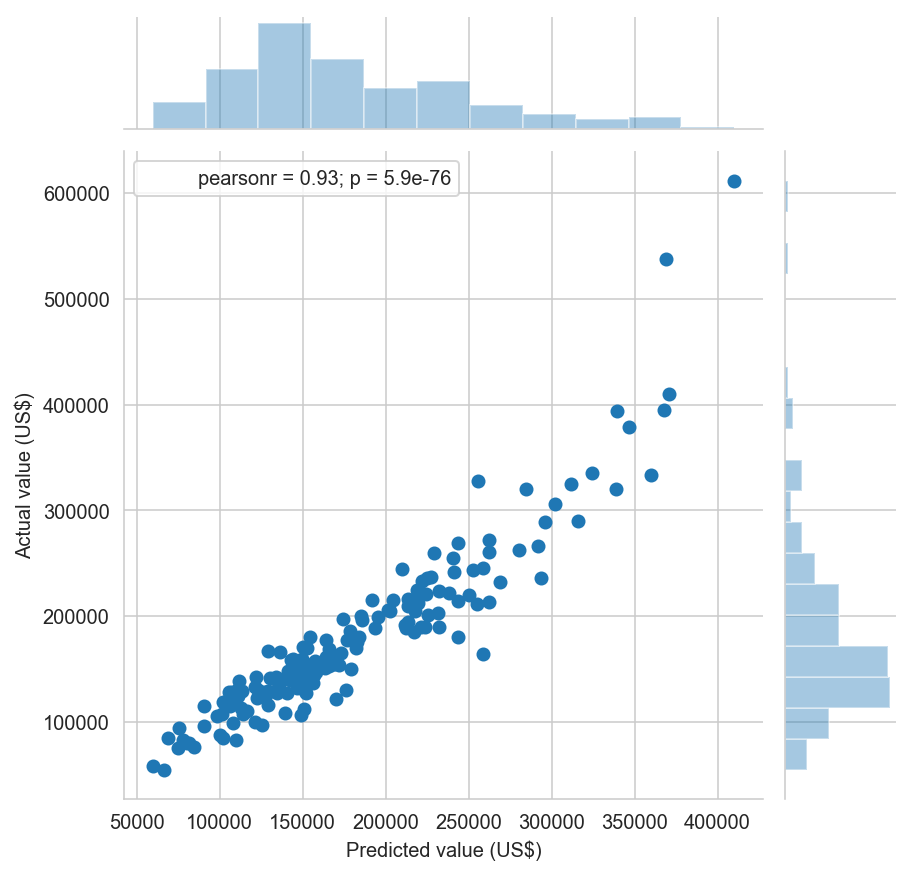

In [124]:
# Linear Regression
from sklearn.linear_model import Ridge, Lasso, ElasticNet, LinearRegression, RidgeCV, LassoCV, ElasticNetCV
from sklearn.model_selection import cross_val_score, train_test_split, cross_val_predict

lm = LinearRegression()
lm.fit(Xs_train_reno, y_train_reno)

print('Intercept : ', lm.intercept_)
print('Coefficients : ', lm.coef_)

print('Trained model score : ', lm.score(Xs_train_reno, y_train_reno))
print('Test data score : ', lm.score(Xs_test_reno, y_test_reno))

predictions_reno = lm.predict(Xs_test_reno)
plot_reno_lr = sns.jointplot(predictions_reno, y_test_reno)
plot_reno_lr.annotate(stats.pearsonr)
plot_reno_lr.set_axis_labels('Predicted value (US$)', 'Actual value (US$)')

The starting price (intercept) of ~$180,000 remains the same whether you include the renovatable features or not. The correlation is slightly better in comparison to a model with fixed features only, but not a major difference.

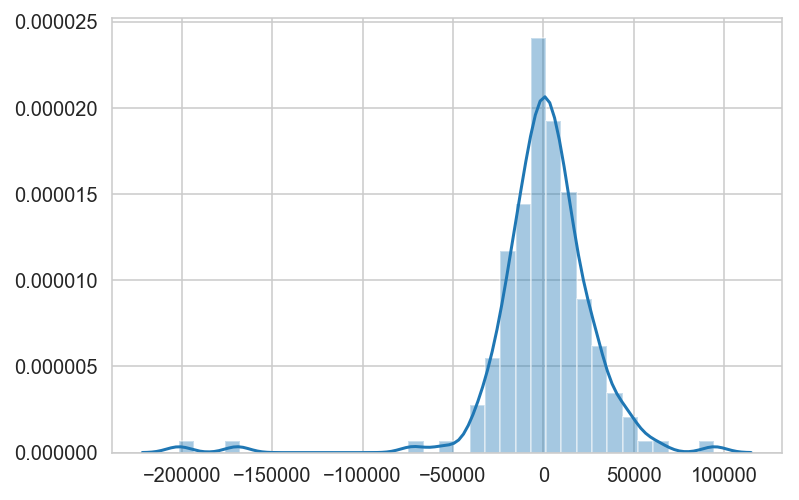

In [134]:
# Check the distribution of residuals
sns.distplot(predictions_reno - y_test_reno)

#### Train & Test model using feature selected by SelectKBest

In [137]:
from sklearn.feature_selection import SelectKBest, f_regression
X_reno = house_reno_dummied.drop(columns = ['SalePrice'])
y_reno = house_reno_dummied['SalePrice']

# Initialise skb
skb = SelectKBest(f_regression, k=5)

# Find kbest by examining the F-score
# F-scores are the test statistic for the F-test, and they represent the ratio between ..
# .. the explained and the unexplained variance
skb.fit(X_train_reno, y_train_reno)


kbest_reno = pd.DataFrame({'feature_skb_reno': X_reno.columns.values.tolist(), 
                      'f_score_reno': skb.scores_.tolist()}).sort_values('f_score_reno', ascending = False)

kbest_reno.reset_index(drop = True, inplace = True)
kbest_reno.head()

C:\Users\norik\Anaconda3\lib\site-packages\sklearn\feature_selection\univariate_selection.py:299: RuntimeWarning: invalid value encountered in true_divide
  corr /= X_norms
C:\Users\norik\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in greater
  return (self.a < x) & (x < self.b)
C:\Users\norik\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:877: RuntimeWarning: invalid value encountered in less
  return (self.a < x) & (x < self.b)
C:\Users\norik\Anaconda3\lib\site-packages\scipy\stats\_distn_infrastructure.py:1831: RuntimeWarning: invalid value encountered in less_equal
  cond2 = cond0 & (x <= self.a)


feature_skb_reno  f_score_reno
0    TotalHomeArea   2472.311570
1       GarageArea    951.075805
2          PropAge    589.174047
3       MasVnrArea    362.232562
4    OverallQual_8    353.838781

Trained model score :  0.8869324368693313
Test data score :  0.8497269823321233
Intercept :  179814.61904761905
Coefficients :  [ 2.98640399e+04  5.88916912e+03 -8.04677368e+03  1.96337040e+03
  1.49447455e+04  4.77739225e+03  4.90104490e+03 -4.00458168e+03
  1.65744630e+04  1.74296204e+02  3.16779334e+03  3.06158344e+03
 -6.66387512e+03  6.41128256e+03 -1.25508386e+04  2.66701564e+03
  1.14109095e+04  3.69632093e+03  8.88749612e+02 -2.62752293e+03
 -5.49437653e+03  4.65081861e+03 -4.07981854e+03 -1.38115853e+03
 -2.65583094e+03  1.33583470e+03 -2.70882132e+03  9.07573453e+03
 -5.32586776e+03 -6.81213174e+02 -5.01041068e+02  1.18414689e+03
 -6.57526795e+02  3.68493182e+03  2.04790054e+03 -3.59621220e+02
 -6.91805870e+03  3.17174669e+03  1.91922479e+03  2.01406824e+01
  7.47275268e+02 -1.92327677e+03 -6.26333345e+03  7.46454395e+02
 -1.35750740e+03 -1.43906571e+03 -4.88717129e+02 -3.38352469e+03
 -7.76684911e+02 -1.99989115e+03]


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


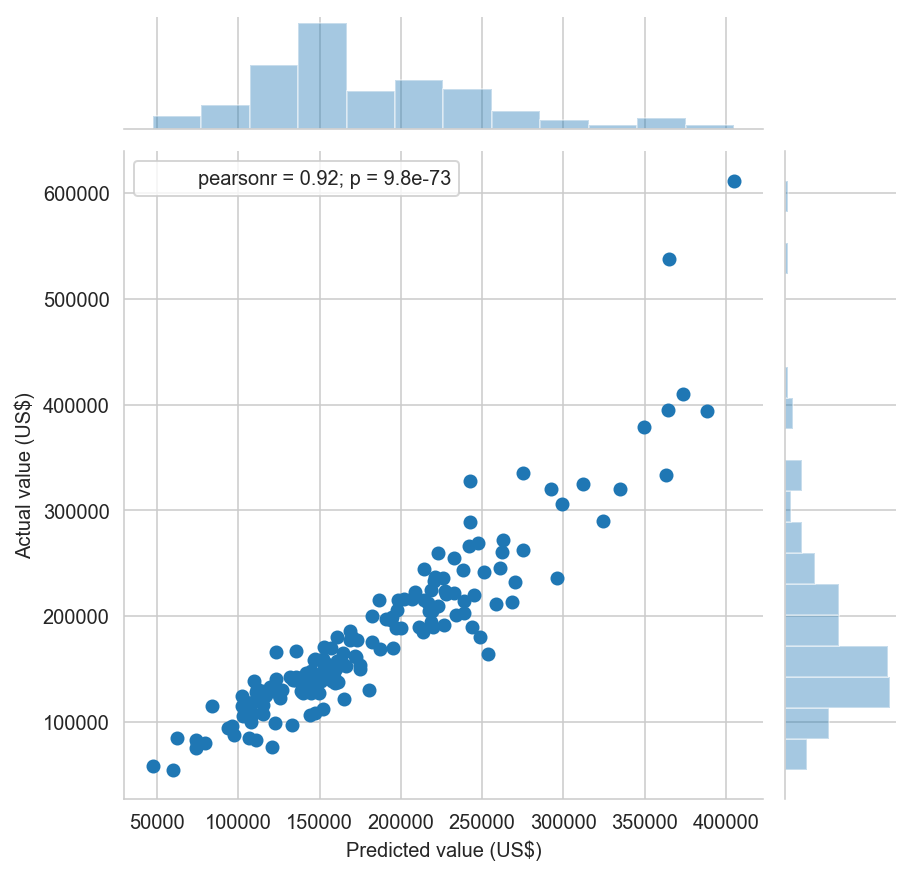

In [125]:
skb_selection_reno = kbest_reno.loc[kbest_reno.f_score_reno > 10, 'feature_skb_reno'].tolist()


lr= LinearRegression()
model_skb_reno = lr.fit(Xs_train_reno_df[skb_selection_reno], y_train_reno_df)
print('Trained model score : ', model_skb_reno.score(Xs_train_reno_df[skb_selection_reno], y_train_reno_df))
print('Test data score : ', model_skb_reno.score(Xs_test_reno_df[skb_selection_reno], y_test_reno_df))

print('Intercept : ', lr.intercept_)
print('Coefficients : ', lr.coef_)

predictions_reno_skb = lr.predict(Xs_test_reno_df[skb_selection_reno])

plot_reno_skb = sns.jointplot(predictions_reno_skb, y_test_fixed)
plot_reno_skb.annotate(stats.pearsonr)
plot_reno_skb.set_axis_labels('Predicted value (US$)', 'Actual value (US$)')

The coefficients suggest that an increase of total home area of 1 sqft results in an increase of value by $29,864 while the property age adversely effect the house price such that the value drops by $8,046 as the age goes up by 1 year. 

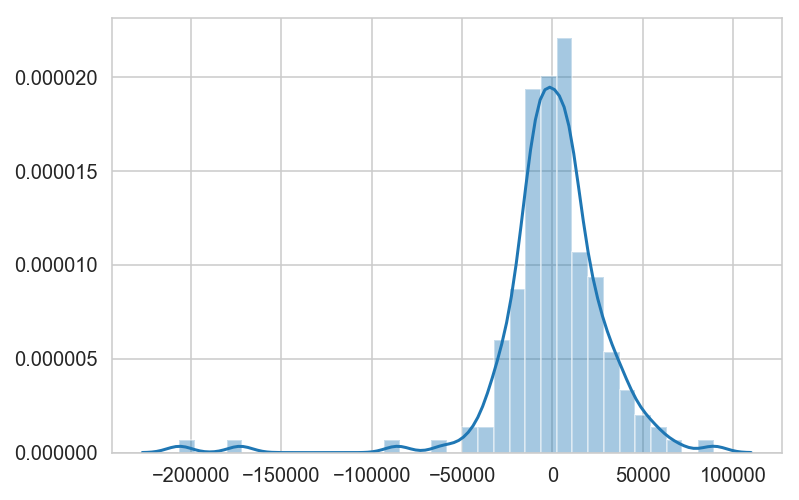

In [133]:
# Check the distribution of residuals
sns.distplot(predictions_reno_skb - y_test_reno)

#### Train & Test model using feature selected by Recursive Feature Elimination 

In [116]:
from sklearn.feature_selection import RFECV
from sklearn.linear_model import LinearRegression

lr = LinearRegression()
selector = RFECV(lr, step=1, cv=10)
selector = selector.fit(X_reno, y_reno)


RFECV = pd.DataFrame({'feature_RFECV_reno': X_reno.columns.values.tolist(),
                      'support_reno': selector.support_,
                      'ranking_reno': selector.ranking_}).sort_values('ranking_reno', ascending = True)

RFECV.reset_index(drop = True, inplace = True)
RFECV

feature_RFECV_reno  support_reno  ranking_reno
0              LotFrontage          True             1
1      Exterior1st_WdShing          True             1
2      Exterior1st_Wd Sdng          True             1
3      Exterior1st_VinylSd          True             1
4       Exterior1st_Stucco          True             1
5        Exterior1st_Stone          True             1
6      Exterior1st_Plywood          True             1
7      Exterior1st_MetalSd          True             1
8      Exterior1st_ImStucc          True             1
9      Exterior1st_HdBoard          True             1
10     Exterior1st_CemntBd          True             1
11      Exterior1st_CBlock          True             1
12     Exterior1st_BrkFace          True             1
13     Exterior1st_BrkComm          True             1
14     Exterior1st_AsphShn          True             1
15           OverallCond_9          True             1
16           OverallCond_8          True             1
17           OverallCond_7          True             1
18     Exterior2nd_AsphShn          True             1
19     Exterior2nd_Brk Cmn          True             1
20     Exterior2nd_BrkFace          True             1
21      Exterior2nd_CBlock          True             1
22        GarageFinish_RFn          True             1
23  BsmtFinType1_not_avail          True             1
24        BsmtFinType1_Unf          True             1
25        BsmtFinType1_Rec          True             1
26        BsmtFinType1_LwQ          True             1
27        BsmtFinType1_GLQ          True             1
28        BsmtFinType1_BLQ          True             1
29     Exterior2nd_Wd Shng          True             1
..                     ...           ...           ...
56             OpenPorchSF          True             1
57              WoodDeckSF          True             1
58              GarageArea          True             1
59           TotalHomeArea          True             1
60              MasVnrArea          True             1
61                 PropAge          True             1
62    Neighborhood_BrkSide          True             1
63        GarageFinish_Unf          True             1
64     Neighborhood_NWAmes          True             1
65    Neighborhood_NridgHt          True             1
66           OverallCond_2          True             1
67           OverallQual_9          True             1
68           OverallQual_8          True             1
69           OverallQual_7          True             1
70           OverallQual_6          True             1
71           OverallQual_5          True             1
72           OverallQual_4          True             1
73           OverallQual_3          True             1
74    Neighborhood_NoRidge          True             1
75           OverallQual_2          True             1
76    Neighborhood_Veenker          True             1
77     Neighborhood_Timber          True             1
78    Neighborhood_StoneBr          True             1
79    Neighborhood_Somerst          True             1
80    Neighborhood_SawyerW          True             1
81     Neighborhood_Sawyer          True             1
82      Neighborhood_SWISU          True             1
83    Neighborhood_OldTown          True             1
84          OverallQual_10          True             1
85  GarageFinish_not_avail          True             1

[86 rows x 3 columns]

Trained model score :  0.8992075405069034
Test data score :  -2.523460002840775e+22
Intercept :  179814.61904761905
Coefficients :  [ 3.15536619e+03  1.21001591e+02 -2.12433869e+03 -7.50241467e+03
 -4.12835590e+02 -1.03714142e+02 -1.26434543e+03 -1.84997107e+03
 -6.65205673e+02 -1.05299428e+03 -6.18248478e+02 -5.85298183e+16
  2.01070954e+03 -1.20026951e+03 -1.26659553e+16  5.68350387e+03
  8.39260199e+03  1.32152835e+04  6.60604607e+02  6.98210024e+02
  3.51938611e+02  5.85298183e+16 -1.67460059e+03  2.77360090e+03
 -3.55941865e+03 -1.31619896e+03 -1.37640581e+03  2.50801648e+03
  2.31021897e+02  2.50458986e+02  1.06865347e+04  2.02763025e+03
  1.22931807e+03 -3.24889832e+02 -6.24021536e+02  3.02056594e+02
  6.70041386e+02  8.98854816e+01 -1.87269367e+03  2.17402933e+03
  7.43098650e+03  8.06701286e+03  8.96511923e+02 -5.85110877e+02
  6.74650613e+02  4.60442351e+02 -2.01254029e+03  1.13239468e+03
  4.63881160e+03  1.42933404e+03  7.33214711e+03  2.61279059e+03
  2.63742030e+02  3.389

C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


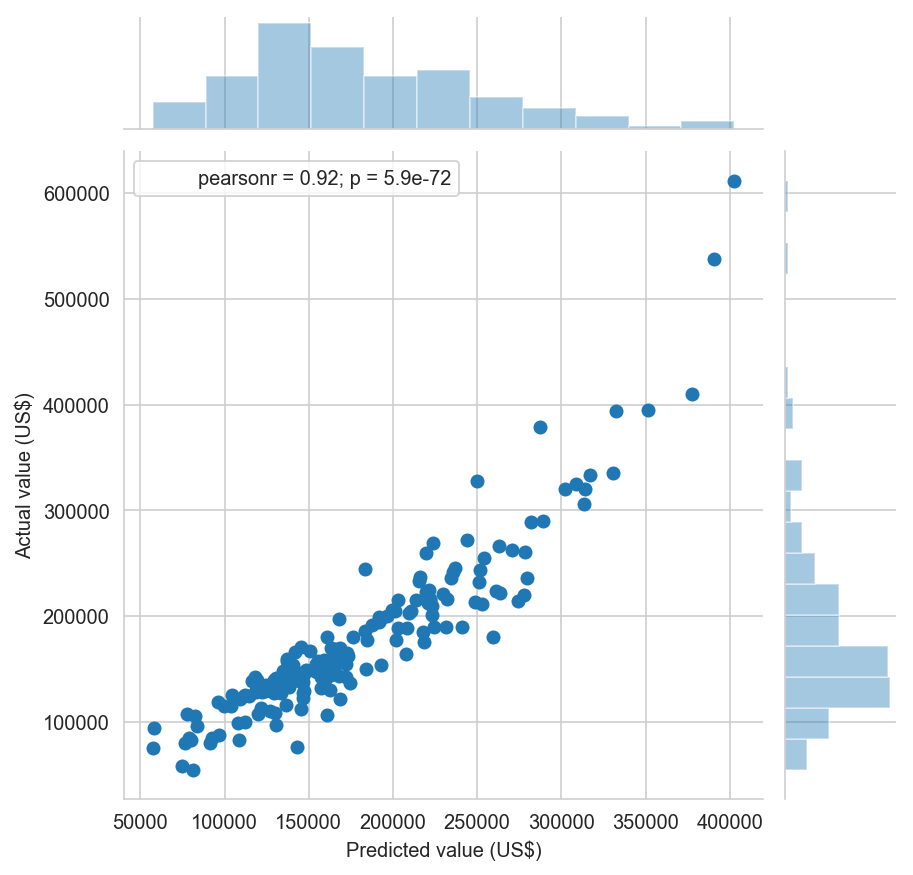

In [126]:
RFECV_selection_reno = RFECV.loc[RFECV.ranking_reno == 1, 'feature_RFECV_reno'].tolist()

from sklearn.linear_model import LinearRegression

lr= LinearRegression()
model_RFECV_reno = lr.fit(Xs_train_reno_df[RFECV_selection_reno], y_train_reno_df)
print('Trained model score : ', model_RFECV_reno.score(Xs_train_reno_df[RFECV_selection_reno], y_train_reno_df))
print('Test data score : ', model_RFECV_reno.score(Xs_test_reno_df[RFECV_selection_reno], y_test_reno_df))

print('Intercept : ', lr.intercept_)
print('Coefficients : ', lr.coef_)

predictions_reno_RFECV = lr.predict(Xs_test_reno_df[RFECV_selection_reno])

plot_reno_RFECV = sns.jointplot(predictions_fixed_RFECV, y_test_reno)
plot_reno_RFECV.annotate(stats.pearsonr)
plot_reno_RFECV.set_axis_labels('Predicted value (US$)', 'Actual value (US$)')

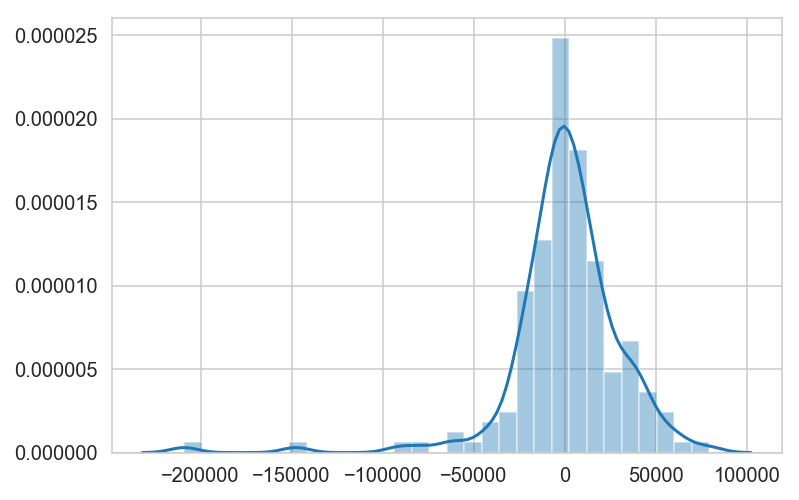

In [132]:
# Check the distribution of residuals
sns.distplot(predictions_fixed_RFECV - y_test_reno)

#### Train & Test model using feature selected by Regularisateion via Lasso

In [118]:
len(X_reno.columns.values.tolist())

86

In [119]:
from sklearn.linear_model import Lasso, LassoCV

X_fixed_reno = house_reno_dummied.drop(columns = ['SalePrice'])
y_fixed_reno = house_reno_dummied['SalePrice']

optimal_lasso = LassoCV()
optimal_lasso.fit(X_fixed_reno, y_fixed_reno)

# find the optimal tuning value, alpha
lasso_alpha = optimal_lasso.alpha_
lasso_coef = optimal_lasso.coef_

lasso = pd.DataFrame({'feature_lasso_reno': X_reno.columns.values.tolist(),
                      'coef_reno': lasso_coef.tolist(),
                      'coef_abs_reno': abs(lasso_coef).tolist()}).sort_values('coef_abs_reno', ascending = False)
lasso.reset_index(drop = True, inplace = True)
    
lasso

feature_lasso_reno   coef_reno  coef_abs_reno
0                  PropAge -473.295506     473.295506
1               GarageArea   61.229601      61.229601
2              OpenPorchSF   60.124755      60.124755
3            TotalHomeArea   58.570787      58.570787
4               MasVnrArea   38.215681      38.215681
5               WoodDeckSF   34.399160      34.399160
6              LotFrontage    0.000000       0.000000
7      Exterior1st_Plywood   -0.000000       0.000000
8      Exterior2nd_Brk Cmn   -0.000000       0.000000
9      Exterior2nd_AsphShn    0.000000       0.000000
10     Exterior1st_WdShing    0.000000       0.000000
11     Exterior1st_Wd Sdng   -0.000000       0.000000
12     Exterior1st_VinylSd    0.000000       0.000000
13      Exterior1st_Stucco    0.000000       0.000000
14       Exterior1st_Stone    0.000000       0.000000
15     Exterior1st_CemntBd    0.000000       0.000000
16     Exterior1st_MetalSd   -0.000000       0.000000
17     Exterior1st_ImStucc    0.000000       0.000000
18     Exterior1st_HdBoard   -0.000000       0.000000
19      Exterior2nd_CBlock   -0.000000       0.000000
20      Exterior1st_CBlock   -0.000000       0.000000
21     Exterior1st_BrkFace    0.000000       0.000000
22     Exterior1st_BrkComm   -0.000000       0.000000
23     Exterior1st_AsphShn    0.000000       0.000000
24     Exterior2nd_BrkFace    0.000000       0.000000
25     Exterior2nd_ImStucc   -0.000000       0.000000
26     Exterior2nd_CmentBd    0.000000       0.000000
27     Exterior2nd_HdBoard   -0.000000       0.000000
28        GarageFinish_Unf   -0.000000       0.000000
29        GarageFinish_RFn   -0.000000       0.000000
..                     ...         ...            ...
56    Neighborhood_Gilbert    0.000000       0.000000
57      Neighborhood_SWISU   -0.000000       0.000000
58    Neighborhood_Edwards   -0.000000       0.000000
59    Neighborhood_Crawfor    0.000000       0.000000
60    Neighborhood_CollgCr   -0.000000       0.000000
61    Neighborhood_ClearCr    0.000000       0.000000
62    Neighborhood_BrkSide    0.000000       0.000000
63     Neighborhood_BrDale   -0.000000       0.000000
64    Neighborhood_Blueste   -0.000000       0.000000
65    Neighborhood_OldTown   -0.000000       0.000000
66     Neighborhood_Sawyer   -0.000000       0.000000
67           OverallCond_6   -0.000000       0.000000
68           OverallQual_5   -0.000000       0.000000
69           OverallCond_4   -0.000000       0.000000
70           OverallCond_3   -0.000000       0.000000
71           OverallCond_2   -0.000000       0.000000
72           OverallQual_9    0.000000       0.000000
73           OverallQual_8    0.000000       0.000000
74           OverallQual_7   -0.000000       0.000000
75           OverallQual_6   -0.000000       0.000000
76           OverallQual_4   -0.000000       0.000000
77    Neighborhood_SawyerW   -0.000000       0.000000
78           OverallQual_3   -0.000000       0.000000
79           OverallQual_2    0.000000       0.000000
80          OverallQual_10    0.000000       0.000000
81    Neighborhood_Veenker    0.000000       0.000000
82     Neighborhood_Timber    0.000000       0.000000
83    Neighborhood_StoneBr    0.000000       0.000000
84    Neighborhood_Somerst    0.000000       0.000000
85  GarageFinish_not_avail    0.000000       0.000000

[86 rows x 3 columns]

Trained model score :  0.7739440640051367
Test data score :  0.7883399663018822
Intercept :  179814.61904761905
Coefficients :  [-16013.82813485  11985.19718127   4578.37729011  41960.01320246
   6190.9477309    4678.05943656]


C:\Users\norik\Anaconda3\lib\site-packages\seaborn\axisgrid.py:1847: UserWarning: JointGrid annotation is deprecated and will be removed in a future release.
  warnings.warn(UserWarning(msg))


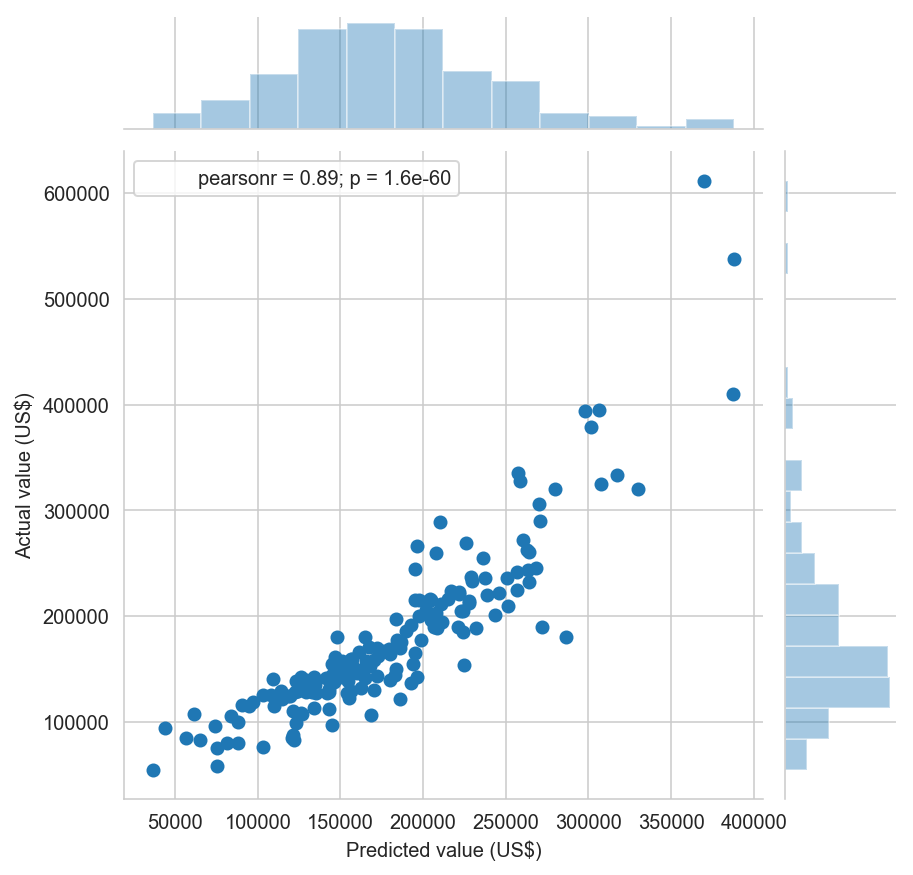

In [127]:
lasso_reg_reno = lasso.loc[lasso.coef_abs_reno > 0, 'feature_lasso_reno'].tolist()

lr = LinearRegression()
lasso_model_reno = lr.fit(Xs_train_reno_df[lasso_reg_reno], y_train_fixed_df)
print('Trained model score : ', lasso_model_reno.score(Xs_train_reno_df[lasso_reg_reno], y_train_reno_df))
print('Test data score : ', lasso_model_reno.score(Xs_test_reno_df[lasso_reg_reno], y_test_reno_df))

print('Intercept : ', lr.intercept_)
print('Coefficients : ', lr.coef_)

predictions_reno_lasso = lr.predict(Xs_test_reno_df[lasso_reg_reno])
plot_reno_lasso = sns.jointplot(predictions_reno_lasso, y_test_reno)
plot_reno_lasso.annotate(stats.pearsonr)
plot_reno_lasso.set_axis_labels('Predicted value (US$)', 'Actual value (US$)')

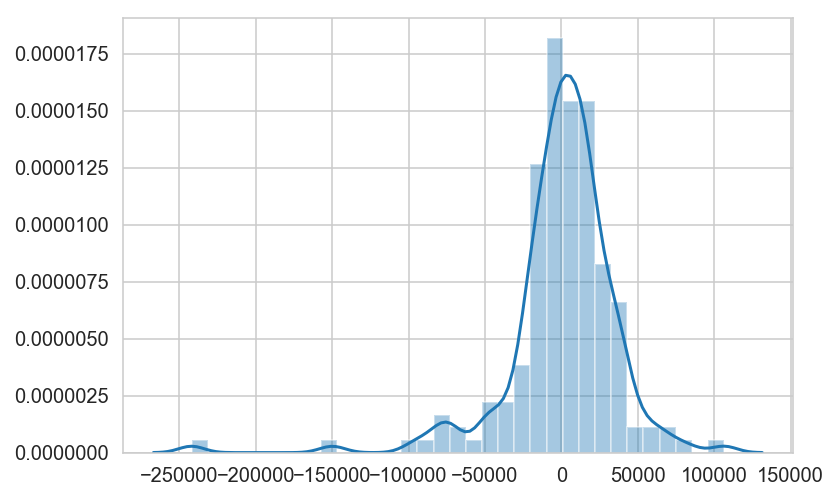

In [129]:
# Check the distribution of residuals
sns.distplot(predictions_reno_lasso - y_test_reno)

Examining the distribution plot of the residuals on all the models, they perform well for the house values less than $500,000, but they show a significant price difference at greater than such value. Comparing SelectKBest, RFE and Lasso Regularization, it seems the RFE gives more normally distributed residuals.

### Conclusion for Question 1:

From the analysis and modeling above, renovatable features 'OverallQual', 'OverallCond', 'Exterior1st', 'Exterior2nd', 'BsmtFinType1', 'GarageFinish' affect the price, so may want to purchase a property if it has a good fixed features and renovate later on & imrpove the quality. You will be able to sell it at a higher price.

Investigate how much of the variance in price remaining is explained by these features.
-> Check if the residuals are normally distribution.

The model with all chosen features including the renovatable ones shows corr= 0.93 with train_r2 = 0.899 and test_r2 = 0.86 which is very slightly better than the model with fixed features only (corr = 0.92 with train_r2 = 0.844 and test_r2 = 0.84).


All models are under-predicted for the high property price. We could potentially separate raws by price range and create a model per class. Additionally, I believe each neighborhood could have its own feature selection, so we should separate per neighborhood and create & compare the models. 


<img src="http://imgur.com/GCAf1UX.png" style="float: left; margin: 25px 15px 0px 0px; height: 25px">

## 3. What property characteristics predict an "abnormal" sale?

---

The `SaleCondition` feature indicates the circumstances of the house sale. From the data file, we can see that the possibilities are:

       Normal	Normal Sale
       Abnorml	Abnormal Sale -  trade, foreclosure, short sale
       AdjLand	Adjoining Land Purchase
       Alloca	Allocation - two linked properties with separate deeds, typically condo with a garage unit	
       Family	Sale between family members
       Partial	Home was not completed when last assessed (associated with New Homes)
       
One of the executives at your company has an "in" with higher-ups at the major regional bank. His friends at the bank have made him a proposal: if he can reliably indicate what features, if any, predict "abnormal" sales (foreclosures, short sales, etc.), then in return the bank will give him first dibs on the pre-auction purchase of those properties (at a dirt-cheap price).

He has tasked you with determining (and adequately validating) which features of a property predict this type of sale. 

---

**Your task:**
1. Determine which features predict the `Abnorml` category in the `SaleCondition` feature.
- Justify your results.

This is a challenging task that tests your ability to perform classification analysis in the face of severe class imbalance. You may find that simply running a classifier on the full dataset to predict the category ends up useless: when there is bad class imbalance classifiers often tend to simply guess the majority class.

It is up to you to determine how you will tackle this problem. I recommend doing some research to find out how others have dealt with the problem in the past. Make sure to justify your solution. Don't worry about it being "the best" solution, but be rigorous.

Be sure to indicate which features are predictive (if any) and whether they are positive or negative predictors of abnormal sales.

In [121]:
house.head()

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
0          60       RL         65.0     8450   Pave      Reg         Lvl   
1          20       RL         80.0     9600   Pave      Reg         Lvl   
2          60       RL         68.0    11250   Pave      IR1         Lvl   
3          70       RL         60.0     9550   Pave      IR1         Lvl   
4          60       RL         84.0    14260   Pave      IR1         Lvl   

  Utilities LotConfig LandSlope  ... MoSold YrSold SaleType SaleCondition  \
0    AllPub    Inside       Gtl  ...      2   2008       WD        Normal   
1    AllPub       FR2       Gtl  ...      5   2007       WD        Normal   
2    AllPub    Inside       Gtl  ...      9   2008       WD        Normal   
3    AllPub    Corner       Gtl  ...      2   2006       WD       Abnorml   
4    AllPub       FR2       Gtl  ...     12   2008       WD        Normal   

  SalePrice  PropAge  PropRemodAge  GarageAge  TotalHomeArea TotalPorch  
0    208500        5             5        5.0           2566         61  
1    181500       31            31       31.0           2524          0  
2    223500        7             6        7.0           2706         42  
3    140000       91            36        8.0           2473        307  
4    250000        8             8        8.0           3343         84  

[5 rows x 81 columns]

In [122]:
house[house['SaleCondition'] == 'Abnorml'].head()

MSSubClass MSZoning  LotFrontage  LotArea Street LotShape LandContour  \
3           70       RL         60.0     9550   Pave      IR1         Lvl   
8           50       RM         51.0     6120   Pave      Reg         Lvl   
19          20       RL         70.0     7560   Pave      Reg         Lvl   
38          20       RL         68.0     7922   Pave      Reg         Lvl   
40          20       RL         84.0     8658   Pave      Reg         Lvl   

   Utilities LotConfig LandSlope  ... MoSold YrSold SaleType SaleCondition  \
3     AllPub    Corner       Gtl  ...      2   2006       WD       Abnorml   
8     AllPub    Inside       Gtl  ...      4   2008       WD       Abnorml   
19    AllPub    Inside       Gtl  ...      5   2009      COD       Abnorml   
38    AllPub    Inside       Gtl  ...      1   2010       WD       Abnorml   
40    AllPub    Inside       Gtl  ...     12   2006       WD       Abnorml   

   SalePrice  PropAge  PropRemodAge  GarageAge  TotalHomeArea TotalPorch  
3     140000       91            36        8.0           2473        307  
8     129900       77            58       77.0           2726        205  
19    139000       51            44       51.0           2368          0  
38    109000       57             3       57.0           2114         52  
40    160000       41            41       41.0           2412        138  

[5 rows x 81 columns]

In [131]:
house_reno_dummied[house_reno_dummied['SalePrice'] > 500000]

LotFrontage  PropAge  MasVnrArea  TotalHomeArea  GarageArea  WoodDeckSF  \
178          63.0        1       748.0           4450        1166           0   
440         105.0        1       200.0           5496         672           0   
769          47.0        7       603.0           4929         841         503   
803         107.0        1       424.0           4556        1020          52   
898         100.0        1       760.0           4694         820           0   
1046         85.0        1       208.0           4860         716         214   

      OpenPorchSF  SalePrice  Neighborhood_Blueste  Neighborhood_BrDale  ...  \
178            60     501837                     0                    0  ...   
440            72     555000                     0                    0  ...   
769            36     538000                     0                    0  ...   
803           170     582933                     0                    0  ...   
898            67     611657                     0                    0  ...   
1046          108     556581                     0                    0  ...   

      Exterior2nd_Wd Shng  BsmtFinType1_BLQ  BsmtFinType1_GLQ  \
178                     0                 0                 1   
440                     0                 0                 1   
769                     1                 0                 0   
803                     0                 0                 0   
898                     0                 0                 1   
1046                    0                 0                 1   

      BsmtFinType1_LwQ  BsmtFinType1_Rec  BsmtFinType1_Unf  \
178                  0                 0                 0   
440                  0                 0                 0   
769                  0                 0                 0   
803                  0                 0                 1   
898                  0                 0                 0   
1046                 0                 0                 0   

      BsmtFinType1_not_avail  GarageFinish_RFn  GarageFinish_Unf  \
178                        0                 0                 0   
440                        0                 0                 0   
769                        0                 0                 0   
803                        0                 1                 0   
898                        0                 0                 0   
1046                       0                 0                 0   

      GarageFinish_not_avail  
178                        0  
440                        0  
769                        0  
803                        0  
898                        0  
1046                       0  

[6 rows x 87 columns]